In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer

import random
import torch
import torch.nn.functional as F


from sentence_transformers import SentenceTransformer, models


from datetime import datetime
from sklearn import svm
from sklearn import metrics

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns


/tmp/ipykernel_2028069/1022608589.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


49972
Size of training set: 16112
Size of validation set: 5371
Size of validation set 5371
26854


Text(0.5, 1.0, 'After Under-Sampling')

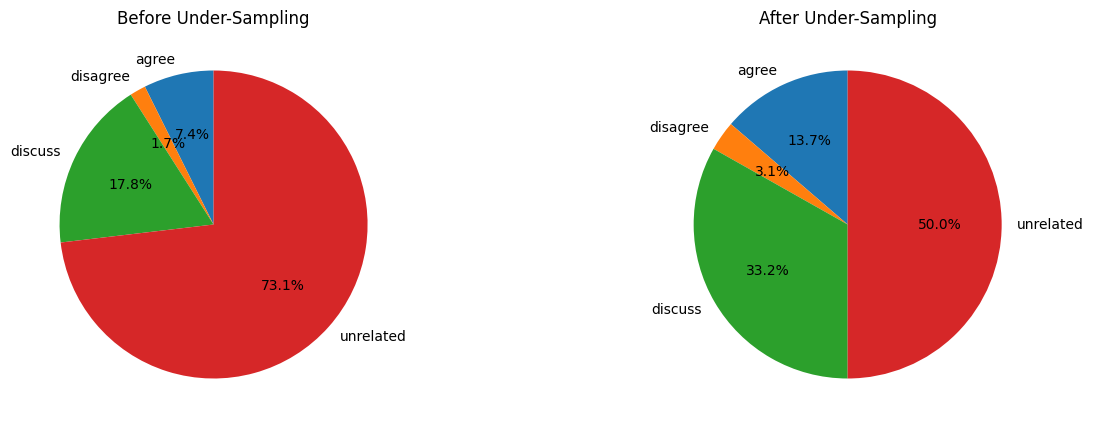

In [2]:
#Load data into train and validation sets

train_bodies = pd.read_csv('train_bodies.csv')
train_stances = pd.read_csv('train_stances.csv')

#Merge article bodies with headlines and stances
data = pd.merge(train_stances, train_bodies, how='left', on='Body ID')

#Encode the stance labels
#data['Stance']=LabelEncoder().fit_transform(data['Stance'])

device = 'cuda' #if torch.cuda.is_available() else 'cpu'

data['Related']=data['Stance'].apply(lambda x: 0 if x=='unrelated' else 1)

stance_percentages = data['Related'].value_counts(normalize=True)
print(len(data))

# Undersample the majority class
related_sample = data[data['Related']==1]


unrelated_sample = data[data['Related']==0].sample(frac=stance_percentages[1]/stance_percentages[0], random_state=0)


dataset = pd.concat([related_sample, unrelated_sample])




#Split data into train, validation, and test sets
#Split data into train/val (80%) and test sets (20%)
X, X_test, Y, Y_test = train_test_split(dataset[['Headline','articleBody']], #Headline and articleBody are the input features
                                                  dataset['Stance'], #Stance is the target variable
                                                  test_size=0.20,
                                                  random_state=10)

#Split train/val into train (60%) and validation (20%) sets
X_train, X_val, Y_train, Y_val = train_test_split(X, 
                                                  Y.values,
                                                  test_size=0.25,
                                                  random_state=10)
# check the size of our datasets
print('Size of training set:',X_train.shape[0])
print('Size of validation set:',X_val.shape[0])
print('Size of validation set',X_test.shape[0])

###Get output labels as binary encodings for related or unrelated

related_train_y = np.where(Y_train == 'unrelated', 0, 1)
related_val_y = np.where(Y_val=='unrelated',0,1)
related_test_y= np.where(Y_test=='unrelated',0,1)


all_labels,all_counts = np.unique(data['Stance'].values,return_counts=True)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.pie(all_counts, labels=all_labels, autopct='%1.1f%%', startangle=90)
plt.title('Before Under-Sampling')

all_labels,all_counts = np.unique(dataset['Stance'].values,return_counts=True)

print(len(dataset))
plt.subplot(1, 2, 2)
plt.pie(all_counts, labels=all_labels, autopct='%1.1f%%', startangle=90)
plt.title('After Under-Sampling')



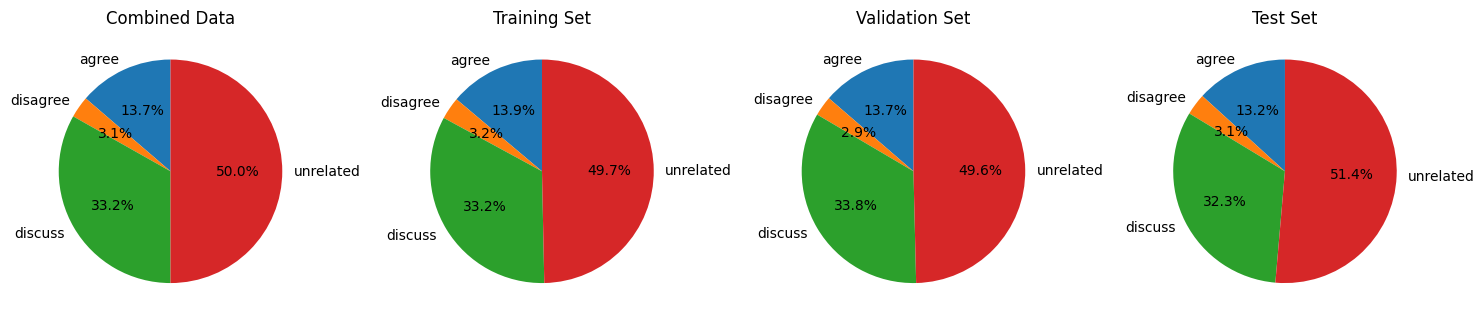

In [3]:

# Plotting pie charts

all_labels,all_counts = np.unique(dataset['Stance'].values,return_counts=True)
# Plot for combined data
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.pie(all_counts, labels=all_labels, autopct='%1.1f%%', startangle=90)
plt.title('Combined Data')

# Plot for training set
train_labels,train_counts = np.unique(Y_train,return_counts=True)

plt.subplot(1, 4, 2)
plt.pie(train_counts, labels=train_labels, autopct='%1.1f%%', startangle=90)
plt.title('Training Set')

# Plot for validation set
val_labels, val_counts = np.unique(Y_val,return_counts=True)
plt.subplot(1, 4, 3)
plt.pie(val_counts, labels=val_labels, autopct='%1.1f%%', startangle=90)
plt.title('Validation Set')

test_labels,test_counts = np.unique(Y_test,return_counts=True)
plt.subplot(1, 4, 4)
plt.pie(test_counts, labels=test_labels, autopct='%1.1f%%', startangle=90)
plt.title('Test Set')

plt.tight_layout()
plt.show()

In [5]:
# Term Frequency-Inverse Document Frequency (TF-IDF) feature extraction


tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)


# list of all headlines and articles
tf_train = X_train.values.flatten() #X_train['Headline'] + ' ' + X_train['articleBody']

# Fit the vectorizer on the headline and body data

start=datetime.now()

print('Fitting the vectorizer on training data')
%time train_tfidf_fit = tfidf.fit(tf_train.astype('U'))


print('TF-IDF Training Data')
train_headlines_tfidf =tfidf.transform(X_train['Headline'].values.astype('U'))
train_bodies_tfidf =tfidf.transform(X_train['articleBody'].values.astype('U'))

print(datetime.now()-start)

start=datetime.now()
print('TF-IDF Validation Data')
val_headlines_tfidf =tfidf.transform(X_val['Headline'].values.astype('U'))
val_bodies_tfidf =tfidf.transform(X_val['articleBody'].values.astype('U'))

print(datetime.now()-start)

start=datetime.now()
print('TF-IDF Test Data')
test_headlines_tfidf =tfidf.transform(X_test['Headline'].values.astype('U'))
test_bodies_tfidf =tfidf.transform(X_test['articleBody'].values.astype('U'))

print(datetime.now()-start)

dictionary = np.asarray(tfidf.get_feature_names_out())
print(dictionary[np.random.randint(0,len(dictionary),size=20)])

Fitting the vectorizer on training data
CPU times: user 6.07 s, sys: 1.44 s, total: 7.52 s
Wall time: 7.51 s
TF-IDF Training Data
0:00:13.238159
TF-IDF Validation Data
0:00:01.630459
TF-IDF Test Data
0:00:01.897863
['pinterest' 'folks' 'يوسف' '140' 'geological' 'umbrella' 'nude' 'aliyu'
 'deliver' 'wintry' 'humvees' 'disgust' 'agents' 'zia' 'recited' 'mark'
 'story_number' 'jazz' 'fingers' 'architectural']


In [3]:
## Tranformer Feature Extraction using Sentence-Transformer ##

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_model=sentence_model.to(device)


start=datetime.now()
print('Transformer Headlines')
train_headlines_transformer = sentence_model.encode(X_train['Headline'].tolist(), convert_to_tensor=True)
train_bodies_transformer = sentence_model.encode(X_train['articleBody'].tolist(), convert_to_tensor=True)

print(datetime.now()-start)

start=datetime.now()
print('Transformer Validation Data')
val_headlines_transformer = sentence_model.encode(X_val['Headline'].tolist(), convert_to_tensor=True)
val_bodies_transformer = sentence_model.encode(X_val['articleBody'].tolist(), convert_to_tensor=True)

print(datetime.now()-start)

start=datetime.now()
print('Transformer Test Data')
test_headlines_transformer = sentence_model.encode(X_test['Headline'].tolist(), convert_to_tensor=True)
test_bodies_transformer = sentence_model.encode(X_test['articleBody'].tolist(), convert_to_tensor=True)

print(datetime.now()-start)




Transformer Headlines
0:01:07.480854
Transformer Validation Data
0:00:21.766205
Transformer Test Data
0:00:21.715233


In [6]:
###Train SVM with TFIDF embeddings

svm_model = svm.SVC(kernel='linear')

print('Fitting SVM with TFIDF')
%time svm_model = svm_model.fit(hstack((train_headlines_tfidf,train_bodies_tfidf)),related_train_y)

print('Predicting classification')
tfidf_svm_predict = svm_model.predict(hstack((val_headlines_tfidf,val_bodies_tfidf)))

#Get binary validation labels

print(metrics.classification_report(related_val_y, tfidf_svm_predict))


Fitting SVM with TFIDF
CPU times: user 6min 33s, sys: 887 ms, total: 6min 34s
Wall time: 6min 34s
Predicting classification
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2665
           1       0.76      0.74      0.75      2706

    accuracy                           0.75      5371
   macro avg       0.75      0.75      0.75      5371
weighted avg       0.75      0.75      0.75      5371



In [7]:
#Train SVM with TFIDF

svm_transformer = svm.SVC(kernel='linear')
print('Fitting SVI with Transformer')
%time svm_transformer = svm_transformer.fit(torch.hstack((train_headlines_transformer,train_bodies_transformer)).cpu(),related_train_y)
#Predict validation set with Transformer embeddings


print('Predicting classification')
%time transformer_svm_predict = svm_transformer.predict(torch.hstack((val_headlines_transformer,val_bodies_transformer)).cpu())

print(metrics.classification_report(related_val_y, transformer_svm_predict))


Fitting SVI with Transformer
CPU times: user 2min 44s, sys: 528 ms, total: 2min 45s
Wall time: 2min 44s
Predicting classification
CPU times: user 42.5 s, sys: 27.9 ms, total: 42.6 s
Wall time: 42.5 s
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      2665
           1       0.65      0.70      0.68      2706

    accuracy                           0.66      5371
   macro avg       0.66      0.66      0.66      5371
weighted avg       0.66      0.66      0.66      5371



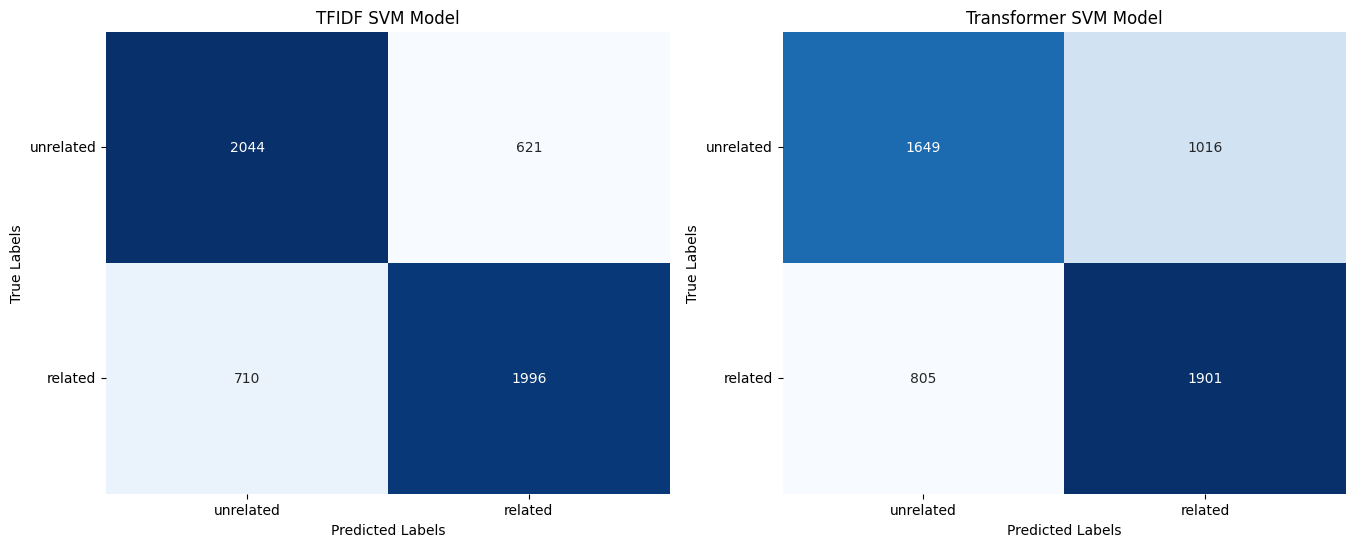

In [15]:
# Define class labels
class_labels = ['unrelated', 'related']
# Compute confusion matrix for TFIDF SVM model
conf_matrix_tfidf = confusion_matrix(related_val_y, tfidf_svm_predict)

# Compute confusion matrix for Transformer SVM model
conf_matrix_transformer = confusion_matrix(related_val_y, transformer_svm_predict)

# Define function to plot confusion matrix with class labels
def plot_confusion_matrix(targets,predictions, title, ax):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticks(ticks=np.arange(len(class_labels))+0.5)
    ax.set_xticklabels(class_labels)
    ax.set_yticks(ticks=np.arange(len(class_labels))+0.5)
    ax.set_yticklabels(class_labels, rotation=0)

# Create figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot confusion matrix for TFIDF SVM model with class labels
plot_confusion_matrix(conf_matrix_tfidf, 'TFIDF SVM Model', axes[0])

# Plot confusion matrix for Transformer SVM model with class labels
plot_confusion_matrix(conf_matrix_transformer, 'Transformer SVM Model', axes[1])

# Adjust layout
plt.show()


In [4]:
###   RELATED MODEL - LSTM


import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    



In [8]:
class TFIDFDataset(Dataset):
    def __init__(self, Headlines, Bodies, Stances):
        self.Headlines = Headlines
        self.Bodies = Bodies
        self.Stances = Stances

    def __len__(self):
        return len(self.Stances)

    def __getitem__(self, idx):
        headline = self.Headlines[idx].toarray().flatten()
        body = self.Bodies[idx].toarray().flatten()
        stance = self.Stances[idx]
        text=torch.from_numpy(np.stack((np.array(headline),np.array(body)))).float().to(device)
        
        return text , torch.tensor(stance).float()

tfidf_train_dataset = TFIDFDataset(train_headlines_tfidf, train_bodies_tfidf, related_train_y)
tfidf_val_dataset = TFIDFDataset(val_headlines_tfidf, val_bodies_tfidf, related_val_y)
tfidf_test_dataset= TFIDFDataset(test_headlines_tfidf, test_bodies_tfidf, related_test_y)

tfidf_LSTM_losses=[]

In [5]:
class TransformerDataset(Dataset):
    def __init__(self, Headlines, Bodies, Stances):
        self.Headlines = Headlines
        self.Bodies = Bodies
        self.Stances = Stances

    def __len__(self):
        return len(self.Stances)

    def __getitem__(self, idx):
        headline = self.Headlines[idx]
        body = self.Bodies[idx]
        stance = self.Stances[idx]
        text=torch.stack((headline,body)).float().to(device)
        
        return text , torch.tensor(stance).float()
    

transformer_train_dataset = TransformerDataset(train_headlines_transformer, train_bodies_transformer, related_train_y)
transformer_val_dataset = TransformerDataset(val_headlines_transformer, val_bodies_transformer, related_val_y)
transformer_test_dataset = TransformerDataset(test_headlines_transformer, test_bodies_transformer, related_test_y)

transformer_LSTM_losses=[]

In [6]:
def train_lstm(train_dataset, val_dataset,input_size,num_epochs = 100,
    learning_rate = 0.001,
    batch_size=128,
    hidden_size = 512,filename='best_weights.pt', early_stop=True):
    
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters 
    
    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(val_dataset , batch_size = batch_size , shuffle=False)

    #Define lstm
    output_dim=1
    lstm_model = LSTM(input_size, hidden_size,output_dim).to(device)

    criterion = nn.BCEWithLogitsLoss()
    criterion=criterion.to(device)
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=1e-5)  

    loss_increase_counter=0


    best_val_loss = float('inf')
    best_val_epoch=0
    train_losses=[]
    val_losses=[]
    for epoch in range(num_epochs):
        epoch_loss=0
        val_epoch_loss=0
        print(f'Epoch {epoch}')
        lstm_model.train()
        for i, (text, stance) in enumerate(tqdm(train_loader)):  
            stance=stance.to(device)

            optimizer.zero_grad()

            # Forward pass
            predictions = lstm_model(text)

            outputs = predictions.squeeze(1).to(torch.float32)

            loss = criterion(outputs, stance.to(torch.float32))


            # Backward and optimize
            loss.backward()
            optimizer.step()

            epoch_loss+=loss.item()

        train_loss= epoch_loss/len(train_loader)


        lstm_model.eval()
        with torch.no_grad():
            epoch_loss=0
            for i, (text,stance) in enumerate(tqdm(val_loader)):
                stance=stance.to(device)
                predictions = lstm_model(text)
                outputs = predictions.squeeze(1).to(torch.float32)
                loss = criterion(outputs, stance.to(torch.float32))

                val_epoch_loss+=loss.item()

            val_loss = val_epoch_loss / len(val_loader)

            if val_loss<best_val_loss:
                best_val_loss = val_loss
                best_val_epoch=epoch
                torch.save(lstm_model.state_dict(), filename)
                print(f'Best validation loss: {val_loss}')
                print('Model saved')
                loss_increase_counter=0
            elif val_loss-last<0 and loss_increase_counter>0:
                loss_increase_counter-=1
            elif early_stop:
                loss_increase_counter+=1


        print(f'Epoch: {epoch}')
        print(f'\tTrain Loss:{train_loss}')
        print(f'\tValidation Loss: {val_loss}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        last=val_loss
        if loss_increase_counter>5:
            print("Model stopped early at epoch ",epoch)
            break
    return [best_val_epoch, train_losses, val_losses]

def plot_losses(best_val_epoch, train_losses, val_losses,model_name):
    save_dir = 'loss_plots'
    os.makedirs(save_dir, exist_ok=True)

    # Plotting training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.axvline(x=best_val_epoch+1, color='r', linestyle='--', label='Best Validation Loss')


    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Losses - {model_name}')

    # Adding legend
    plt.legend()

    # Save the plot
    plt.savefig(os.path.join(save_dir, f'loss_plot_{model_name}.png'))

    # Display the plot for each set of parameters
    plt.show()

In [7]:
def evaluate_lstm(test_dataset,model_file):
    batch_size = 128 
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model = LSTM(test_dataset[0][0].shape[1],512,1)
    model.load_state_dict(torch.load(model_file))
    model=model.to(device)
    model.eval()

    # Lists to store predictions
    all_predictions = []
    all_targets = []

    # Inference loop
    with torch.no_grad():
        for text, stance in test_loader:
            # Send data to the device
            text = text.to(device)

            # Forward pass
            predictions = model(text)

            # Convert predictions to probabilities and append to the list
            probabilities = torch.sigmoid(predictions).cpu().numpy().tolist()
            all_predictions.extend(probabilities)

            all_targets.extend(stance.cpu().numpy().tolist())

    # Convert predictions and targets to NumPy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)



    # Convert probabilities to binary predictions
    binary_predictions = (all_predictions > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(all_targets, binary_predictions)
    precision = precision_score(all_targets, binary_predictions)
    recall = recall_score(all_targets, binary_predictions)
    f1 = f1_score(all_targets, binary_predictions)
    roc_auc = roc_auc_score(all_targets, all_predictions)

    # Print the summary
    print(f'Summary of Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'ROC-AUC Score: {roc_auc:.4f}')


In [16]:
#Training and evaluating TFIDF LSTM

tfidf_lstm_losses = train_lstm(tfidf_train_dataset,tfidf_val_dataset,train_headlines_tfidf.shape[1], num_epochs= 200, filename='TFIDF_LSTM200.pt')

Epoch 0


100%|██████████| 42/42 [00:02<00:00, 14.38it/s]


Best validation loss: 0.5097599597204299
Model saved
Epoch: 0
	Train Loss:0.6030930188440141
	Validation Loss: 0.5097599597204299
Epoch 1


100%|██████████| 42/42 [00:02<00:00, 14.49it/s]


Best validation loss: 0.4171292952128819
Model saved
Epoch: 1
	Train Loss:0.434529893928104
	Validation Loss: 0.4171292952128819
Epoch 2


100%|██████████| 42/42 [00:02<00:00, 14.48it/s]


Best validation loss: 0.3434509315661022
Model saved
Epoch: 2
	Train Loss:0.3229835545496335
	Validation Loss: 0.3434509315661022
Epoch 3


100%|██████████| 42/42 [00:02<00:00, 14.30it/s]


Best validation loss: 0.33228460344530286
Model saved
Epoch: 3
	Train Loss:0.2532396132037753
	Validation Loss: 0.33228460344530286
Epoch 4


100%|██████████| 42/42 [00:02<00:00, 14.52it/s]


Best validation loss: 0.3086248402084623
Model saved
Epoch: 4
	Train Loss:0.21784449552023222
	Validation Loss: 0.3086248402084623
Epoch 5


100%|██████████| 42/42 [00:02<00:00, 14.46it/s]


Epoch: 5
	Train Loss:0.19039963144395086
	Validation Loss: 0.3160341903567314
Epoch 6


100%|██████████| 42/42 [00:02<00:00, 14.55it/s]


Epoch: 6
	Train Loss:0.17192583880017673
	Validation Loss: 0.31055384767907007
Epoch 7


100%|██████████| 42/42 [00:02<00:00, 14.47it/s]


Epoch: 7
	Train Loss:0.1578569622148597
	Validation Loss: 0.3205154055640811
Epoch 8


100%|██████████| 42/42 [00:02<00:00, 14.55it/s]


Epoch: 8
	Train Loss:0.14436591582165825
	Validation Loss: 0.3100186167728333
Epoch 9


100%|██████████| 42/42 [00:02<00:00, 14.58it/s]


Epoch: 9
	Train Loss:0.1364018994546126
	Validation Loss: 0.31485852208875476
Epoch 10


100%|██████████| 42/42 [00:02<00:00, 14.55it/s]


Epoch: 10
	Train Loss:0.12544268337152306
	Validation Loss: 0.3229987241682552
Epoch 11


100%|██████████| 42/42 [00:02<00:00, 14.50it/s]


Best validation loss: 0.30394648299330757
Model saved
Epoch: 11
	Train Loss:0.11540330012166311
	Validation Loss: 0.30394648299330757
Epoch 12


100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Epoch: 12
	Train Loss:0.1091741429907935
	Validation Loss: 0.33404100970143363
Epoch 13


100%|██████████| 42/42 [00:02<00:00, 14.64it/s]


Epoch: 13
	Train Loss:0.09950311898830391
	Validation Loss: 0.31934760156131925
Epoch 14


100%|██████████| 42/42 [00:02<00:00, 14.75it/s]


Epoch: 14
	Train Loss:0.09001621388135449
	Validation Loss: 0.3080499569574992
Epoch 15


100%|██████████| 42/42 [00:02<00:00, 14.68it/s]


Best validation loss: 0.3022855864394279
Model saved
Epoch: 15
	Train Loss:0.08195588498243264
	Validation Loss: 0.3022855864394279
Epoch 16


100%|██████████| 42/42 [00:02<00:00, 14.81it/s]


Best validation loss: 0.28772232220286414
Model saved
Epoch: 16
	Train Loss:0.06570678939008051
	Validation Loss: 0.28772232220286414
Epoch 17


100%|██████████| 42/42 [00:02<00:00, 14.58it/s]


Epoch: 17
	Train Loss:0.05557525707113128
	Validation Loss: 0.3007581957748958
Epoch 18


100%|██████████| 42/42 [00:02<00:00, 14.53it/s]


Best validation loss: 0.26640287165840465
Model saved
Epoch: 18
	Train Loss:0.048289516955495826
	Validation Loss: 0.26640287165840465
Epoch 19


100%|██████████| 42/42 [00:02<00:00, 14.51it/s]


Epoch: 19
	Train Loss:0.041252727871612896
	Validation Loss: 0.2732407150878793
Epoch 20


100%|██████████| 42/42 [00:02<00:00, 14.50it/s]


Best validation loss: 0.25960623242315795
Model saved
Epoch: 20
	Train Loss:0.03550741522912941
	Validation Loss: 0.25960623242315795
Epoch 21


100%|██████████| 42/42 [00:02<00:00, 14.53it/s]


Epoch: 21
	Train Loss:0.031110028011931315
	Validation Loss: 0.26726259681440534
Epoch 22


100%|██████████| 42/42 [00:02<00:00, 14.47it/s]


Epoch: 22
	Train Loss:0.027171244375437262
	Validation Loss: 0.26089092681095716
Epoch 23


100%|██████████| 42/42 [00:02<00:00, 14.62it/s]


Best validation loss: 0.2555582496736731
Model saved
Epoch: 23
	Train Loss:0.023225126551493766
	Validation Loss: 0.2555582496736731
Epoch 24


100%|██████████| 42/42 [00:02<00:00, 14.42it/s]


Epoch: 24
	Train Loss:0.025504578717999042
	Validation Loss: 0.26184489329655963
Epoch 25


100%|██████████| 42/42 [00:02<00:00, 14.57it/s]


Best validation loss: 0.2516309017581599
Model saved
Epoch: 25
	Train Loss:0.02422412748389419
	Validation Loss: 0.2516309017581599
Epoch 26


100%|██████████| 42/42 [00:02<00:00, 14.49it/s]


Best validation loss: 0.24896629615908578
Model saved
Epoch: 26
	Train Loss:0.01999067150366803
	Validation Loss: 0.24896629615908578
Epoch 27


100%|██████████| 42/42 [00:02<00:00, 14.60it/s]


Best validation loss: 0.23648618445509956
Model saved
Epoch: 27
	Train Loss:0.01994383037607703
	Validation Loss: 0.23648618445509956
Epoch 28


100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Epoch: 28
	Train Loss:0.017076607331604002
	Validation Loss: 0.24652064290075076
Epoch 29


100%|██████████| 42/42 [00:03<00:00, 13.93it/s]


Epoch: 29
	Train Loss:0.012879130090512926
	Validation Loss: 0.25087355432056246
Epoch 30


100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Epoch: 30
	Train Loss:0.012726046954325977
	Validation Loss: 0.24866377615502902
Epoch 31


100%|██████████| 42/42 [00:02<00:00, 14.48it/s]


Epoch: 31
	Train Loss:0.012997284638769334
	Validation Loss: 0.25747650773042724
Epoch 32


100%|██████████| 42/42 [00:02<00:00, 14.50it/s]


Epoch: 32
	Train Loss:0.012712287635261577
	Validation Loss: 0.24706137189198107
Epoch 33


100%|██████████| 42/42 [00:02<00:00, 14.49it/s]


Epoch: 33
	Train Loss:0.013178658335366182
	Validation Loss: 0.2650121477033411
Epoch 34


100%|██████████| 42/42 [00:02<00:00, 14.51it/s]


Best validation loss: 0.2279325123166754
Model saved
Epoch: 34
	Train Loss:0.016818355478804618
	Validation Loss: 0.2279325123166754
Epoch 35


100%|██████████| 42/42 [00:02<00:00, 14.46it/s]


Epoch: 35
	Train Loss:0.011358889326127984
	Validation Loss: 0.2302233644184612
Epoch 36


100%|██████████| 42/42 [00:02<00:00, 14.56it/s]


Best validation loss: 0.22207981818133876
Model saved
Epoch: 36
	Train Loss:0.008196442997792647
	Validation Loss: 0.22207981818133876
Epoch 37


100%|██████████| 42/42 [00:02<00:00, 14.50it/s]


Epoch: 37
	Train Loss:0.009596103214703146
	Validation Loss: 0.22250413947871753
Epoch 38


100%|██████████| 42/42 [00:02<00:00, 14.55it/s]


Epoch: 38
	Train Loss:0.009436874886945126
	Validation Loss: 0.23816535071957678
Epoch 39


100%|██████████| 42/42 [00:02<00:00, 14.46it/s]


Epoch: 39
	Train Loss:0.01086451131702652
	Validation Loss: 0.2293468215281055
Epoch 40


100%|██████████| 42/42 [00:02<00:00, 14.53it/s]


Epoch: 40
	Train Loss:0.012202091193536208
	Validation Loss: 0.23796701280488855
Epoch 41


100%|██████████| 42/42 [00:02<00:00, 14.45it/s]


Best validation loss: 0.21760808250733785
Model saved
Epoch: 41
	Train Loss:0.014373902449502594
	Validation Loss: 0.21760808250733785
Epoch 42


100%|██████████| 42/42 [00:02<00:00, 14.53it/s]


Best validation loss: 0.21561784474622636
Model saved
Epoch: 42
	Train Loss:0.0082787169875311
	Validation Loss: 0.21561784474622636
Epoch 43


100%|██████████| 42/42 [00:02<00:00, 14.44it/s]


Epoch: 43
	Train Loss:0.005979205136157809
	Validation Loss: 0.21610993271072707
Epoch 44


100%|██████████| 42/42 [00:02<00:00, 14.46it/s]


Epoch: 44
	Train Loss:0.00922234248118623
	Validation Loss: 0.22210919945722535
Epoch 45


100%|██████████| 42/42 [00:02<00:00, 14.44it/s]


Best validation loss: 0.2106566351084482
Model saved
Epoch: 45
	Train Loss:0.009801183625804408
	Validation Loss: 0.2106566351084482
Epoch 46


100%|██████████| 42/42 [00:02<00:00, 14.52it/s]


Best validation loss: 0.2103766102698587
Model saved
Epoch: 46
	Train Loss:0.007669303874810418
	Validation Loss: 0.2103766102698587
Epoch 47


100%|██████████| 42/42 [00:02<00:00, 14.48it/s]


Best validation loss: 0.20986102157760234
Model saved
Epoch: 47
	Train Loss:0.00753455070061757
	Validation Loss: 0.20986102157760234
Epoch 48


100%|██████████| 42/42 [00:02<00:00, 14.48it/s]


Best validation loss: 0.20173804080557256
Model saved
Epoch: 48
	Train Loss:0.005720490667348106
	Validation Loss: 0.20173804080557256
Epoch 49


100%|██████████| 42/42 [00:02<00:00, 14.56it/s]


Epoch: 49
	Train Loss:0.004671517634830836
	Validation Loss: 0.2022104679296414
Epoch 50


100%|██████████| 42/42 [00:02<00:00, 14.43it/s]


Best validation loss: 0.2002058085941133
Model saved
Epoch: 50
	Train Loss:0.00413841747360984
	Validation Loss: 0.2002058085941133
Epoch 51


100%|██████████| 42/42 [00:02<00:00, 14.37it/s]


Epoch: 51
	Train Loss:0.005108085695639371
	Validation Loss: 0.2034628666227772
Epoch 52


100%|██████████| 42/42 [00:02<00:00, 14.47it/s]


Epoch: 52
	Train Loss:0.006224532984936285
	Validation Loss: 0.20825669151686488
Epoch 53


100%|██████████| 42/42 [00:02<00:00, 14.41it/s]


Epoch: 53
	Train Loss:0.014271575806011993
	Validation Loss: 0.23759122015464873
Epoch 54


100%|██████████| 42/42 [00:02<00:00, 14.63it/s]


Epoch: 54
	Train Loss:0.021565955565569714
	Validation Loss: 0.20311649117086614
Epoch 55


100%|██████████| 42/42 [00:02<00:00, 14.58it/s]


Best validation loss: 0.19494311298642839
Model saved
Epoch: 55
	Train Loss:0.01189931162950834
	Validation Loss: 0.19494311298642839
Epoch 56


100%|██████████| 42/42 [00:02<00:00, 14.76it/s]


Best validation loss: 0.1798757972816626
Model saved
Epoch: 56
	Train Loss:0.0073893518346021805
	Validation Loss: 0.1798757972816626
Epoch 57


100%|██████████| 42/42 [00:02<00:00, 14.77it/s]


Epoch: 57
	Train Loss:0.003640550796666907
	Validation Loss: 0.18775144698364393
Epoch 58


100%|██████████| 42/42 [00:02<00:00, 14.66it/s]


Best validation loss: 0.17592656195518516
Model saved
Epoch: 58
	Train Loss:0.0027613452827883146
	Validation Loss: 0.17592656195518516
Epoch 59


100%|██████████| 42/42 [00:02<00:00, 14.68it/s]


Epoch: 59
	Train Loss:0.002510654204155481
	Validation Loss: 0.1769710529950403
Epoch 60


100%|██████████| 42/42 [00:02<00:00, 14.78it/s]


Epoch: 60
	Train Loss:0.0026804661186086752
	Validation Loss: 0.1774569596385672
Epoch 61


100%|██████████| 42/42 [00:02<00:00, 14.66it/s]


Epoch: 61
	Train Loss:0.0028604906872801835
	Validation Loss: 0.17821675663193068
Epoch 62


100%|██████████| 42/42 [00:02<00:00, 14.74it/s]


Epoch: 62
	Train Loss:0.0031090160454845146
	Validation Loss: 0.17756006290160475
Epoch 63


100%|██████████| 42/42 [00:02<00:00, 14.66it/s]


Best validation loss: 0.17448428592511586
Model saved
Epoch: 63
	Train Loss:0.0033929351170266433
	Validation Loss: 0.17448428592511586
Epoch 64


100%|██████████| 42/42 [00:02<00:00, 14.57it/s]


Epoch: 64
	Train Loss:0.003693504495516656
	Validation Loss: 0.1829849909104052
Epoch 65


100%|██████████| 42/42 [00:02<00:00, 14.74it/s]


Epoch: 65
	Train Loss:0.011508715198567462
	Validation Loss: 0.2215415317387808
Epoch 66


100%|██████████| 42/42 [00:02<00:00, 14.58it/s]


Epoch: 66
	Train Loss:0.022257309235144584
	Validation Loss: 0.2272985428571701
Epoch 67


100%|██████████| 42/42 [00:03<00:00, 13.95it/s]


Epoch: 67
	Train Loss:0.012227635930425354
	Validation Loss: 0.19880486847389311
Epoch 68


100%|██████████| 42/42 [00:02<00:00, 14.60it/s]


Epoch: 68
	Train Loss:0.0054745951294159845
	Validation Loss: 0.19588957549560637
Epoch 69


100%|██████████| 42/42 [00:02<00:00, 14.72it/s]


Epoch: 69
	Train Loss:0.00251085274910096
	Validation Loss: 0.17563470257889657
Epoch 70


100%|██████████| 42/42 [00:02<00:00, 14.56it/s]


Epoch: 70
	Train Loss:0.0018978411075843882
	Validation Loss: 0.17569288779937087
Epoch 71


100%|██████████| 42/42 [00:02<00:00, 14.75it/s]


Best validation loss: 0.16561472309487207
Model saved
Epoch: 71
	Train Loss:0.001943470204308156
	Validation Loss: 0.16561472309487207
Epoch 72


100%|██████████| 42/42 [00:02<00:00, 14.69it/s]


Epoch: 72
	Train Loss:0.0022157790344430224
	Validation Loss: 0.16744718008807727
Epoch 73


100%|██████████| 42/42 [00:02<00:00, 14.75it/s]


Epoch: 73
	Train Loss:0.0024084418417058056
	Validation Loss: 0.1682972853027639
Epoch 74


100%|██████████| 42/42 [00:02<00:00, 14.63it/s]


Best validation loss: 0.16214011707121417
Model saved
Epoch: 74
	Train Loss:0.0026206286413417686
	Validation Loss: 0.16214011707121417
Epoch 75


100%|██████████| 42/42 [00:02<00:00, 14.47it/s]


Epoch: 75
	Train Loss:0.002706257789026177
	Validation Loss: 0.16258356321070874
Epoch 76


100%|██████████| 42/42 [00:02<00:00, 14.76it/s]


Epoch: 76
	Train Loss:0.005566811633466315
	Validation Loss: 0.16882526954369886
Epoch 77


100%|██████████| 42/42 [00:02<00:00, 14.49it/s]


Epoch: 77
	Train Loss:0.009819257450992212
	Validation Loss: 0.1905265659803436
Epoch 78


100%|██████████| 42/42 [00:02<00:00, 14.80it/s]


Epoch: 78
	Train Loss:0.020876538193237686
	Validation Loss: 0.18752266892365047
Epoch 79


100%|██████████| 42/42 [00:02<00:00, 14.72it/s]


Best validation loss: 0.1600997226224059
Model saved
Epoch: 79
	Train Loss:0.006962306874652674
	Validation Loss: 0.1600997226224059
Epoch 80


100%|██████████| 42/42 [00:02<00:00, 14.72it/s]


Epoch: 80
	Train Loss:0.004640648126720436
	Validation Loss: 0.16859504474060877
Epoch 81


100%|██████████| 42/42 [00:02<00:00, 14.55it/s]


Best validation loss: 0.15475158490950153
Model saved
Epoch: 81
	Train Loss:0.0021594275774929434
	Validation Loss: 0.15475158490950153
Epoch 82


100%|██████████| 42/42 [00:02<00:00, 14.77it/s]


Best validation loss: 0.1545687285030172
Model saved
Epoch: 82
	Train Loss:0.0016249370292782607
	Validation Loss: 0.1545687285030172
Epoch 83


100%|██████████| 42/42 [00:02<00:00, 14.60it/s]


Epoch: 83
	Train Loss:0.0018014420421668402
	Validation Loss: 0.16121364677590982
Epoch 84


100%|██████████| 42/42 [00:02<00:00, 14.72it/s]


Epoch: 84
	Train Loss:0.002028476512466099
	Validation Loss: 0.1582622711679765
Epoch 85


100%|██████████| 42/42 [00:02<00:00, 14.56it/s]


Epoch: 85
	Train Loss:0.002296754558171545
	Validation Loss: 0.1548222614718335
Epoch 86


100%|██████████| 42/42 [00:02<00:00, 14.79it/s]


Best validation loss: 0.15371073445393926
Model saved
Epoch: 86
	Train Loss:0.0028948153208364687
	Validation Loss: 0.15371073445393926
Epoch 87


100%|██████████| 42/42 [00:02<00:00, 14.57it/s]


Epoch: 87
	Train Loss:0.004412702497257482
	Validation Loss: 0.18068713623852956
Epoch 88


100%|██████████| 42/42 [00:02<00:00, 14.77it/s]


Epoch: 88
	Train Loss:0.005624555961860876
	Validation Loss: 0.1675066440587952
Epoch 89


100%|██████████| 42/42 [00:02<00:00, 14.69it/s]


Epoch: 89
	Train Loss:0.005068890859432045
	Validation Loss: 0.17588735247651735
Epoch 90


100%|██████████| 42/42 [00:02<00:00, 14.74it/s]


Epoch: 90
	Train Loss:0.01688094112914913
	Validation Loss: 0.1698515255536352
Epoch 91


100%|██████████| 42/42 [00:02<00:00, 14.69it/s]


Epoch: 91
	Train Loss:0.011425730521007189
	Validation Loss: 0.16402570025197097
Epoch 92


100%|██████████| 42/42 [00:02<00:00, 14.72it/s]


Epoch: 92
	Train Loss:0.005031501579131665
	Validation Loss: 0.16031823050053345
Epoch 93


100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Best validation loss: 0.1392455892637372
Model saved
Epoch: 93
	Train Loss:0.0020346424980310814
	Validation Loss: 0.1392455892637372
Epoch 94


100%|██████████| 42/42 [00:02<00:00, 14.75it/s]


Epoch: 94
	Train Loss:0.0014854699995974817
	Validation Loss: 0.14417894317635468
Epoch 95


100%|██████████| 42/42 [00:02<00:00, 14.58it/s]


Best validation loss: 0.13749351627415135
Model saved
Epoch: 95
	Train Loss:0.0014898229042984664
	Validation Loss: 0.13749351627415135
Epoch 96


100%|██████████| 42/42 [00:02<00:00, 14.75it/s]


Epoch: 96
	Train Loss:0.0016520940407644957
	Validation Loss: 0.15214733531077704
Epoch 97


100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Epoch: 97
	Train Loss:0.0018293328753243836
	Validation Loss: 0.14987039956308545
Epoch 98


100%|██████████| 42/42 [00:02<00:00, 14.74it/s]


Epoch: 98
	Train Loss:0.0020225356556549078
	Validation Loss: 0.14561518201870577
Epoch 99


100%|██████████| 42/42 [00:02<00:00, 14.58it/s]


Epoch: 99
	Train Loss:0.0021458196828866172
	Validation Loss: 0.15212174833175682
Epoch 100


100%|██████████| 42/42 [00:02<00:00, 14.77it/s]


Epoch: 100
	Train Loss:0.0021827735925196773
	Validation Loss: 0.14531897780086314
Epoch 101


100%|██████████| 42/42 [00:02<00:00, 14.61it/s]


Epoch: 101
	Train Loss:0.0022892671820175436
	Validation Loss: 0.14795208420781863
Epoch 102


100%|██████████| 42/42 [00:02<00:00, 14.72it/s]


Epoch: 102
	Train Loss:0.002931411562871838
	Validation Loss: 0.15626156667158717
Epoch 103


100%|██████████| 42/42 [00:02<00:00, 14.55it/s]


Epoch: 103
	Train Loss:0.004786960367623362
	Validation Loss: 0.16075565195864155
Epoch 104


100%|██████████| 42/42 [00:02<00:00, 14.71it/s]


Epoch: 104
	Train Loss:0.019459903009221076
	Validation Loss: 0.20011320612615063
Epoch 105


100%|██████████| 42/42 [00:02<00:00, 14.91it/s]


Epoch: 105
	Train Loss:0.017530579108833558
	Validation Loss: 0.17753995378457366
Epoch 106


100%|██████████| 42/42 [00:02<00:00, 15.10it/s]


Epoch: 106
	Train Loss:0.003250391200362217
	Validation Loss: 0.15750514387729622
Epoch 107


100%|██████████| 42/42 [00:02<00:00, 14.61it/s]


Epoch: 107
	Train Loss:0.0012902431582684614
	Validation Loss: 0.15655839691559473
Epoch 108


100%|██████████| 42/42 [00:02<00:00, 14.71it/s]


Epoch: 108
	Train Loss:0.00118816677723006
	Validation Loss: 0.1521334426388854
Epoch 109


100%|██████████| 42/42 [00:02<00:00, 14.57it/s]


Epoch: 109
	Train Loss:0.0013050452149140515
	Validation Loss: 0.14703314494164216
Epoch 110


100%|██████████| 42/42 [00:02<00:00, 14.69it/s]


Epoch: 110
	Train Loss:0.0014692386857137853
	Validation Loss: 0.14201412066107705
Epoch 111


100%|██████████| 42/42 [00:02<00:00, 14.60it/s]


Epoch: 111
	Train Loss:0.00163351895568508
	Validation Loss: 0.14641530581173443
Epoch 112


100%|██████████| 42/42 [00:02<00:00, 14.66it/s]


Epoch: 112
	Train Loss:0.0017802508502629483
	Validation Loss: 0.14118123568949245
Epoch 113


100%|██████████| 42/42 [00:02<00:00, 14.64it/s]


Epoch: 113
	Train Loss:0.0019140582539082047
	Validation Loss: 0.1424406153105554
Epoch 114


100%|██████████| 42/42 [00:02<00:00, 14.66it/s]


Epoch: 114
	Train Loss:0.002134540662472506
	Validation Loss: 0.14417350877608573
Epoch 115


100%|██████████| 42/42 [00:02<00:00, 14.70it/s]


Epoch: 115
	Train Loss:0.0035972738775262047
	Validation Loss: 0.15968522731037366
Epoch 116


100%|██████████| 42/42 [00:02<00:00, 14.65it/s]


Epoch: 116
	Train Loss:0.007209568191134918
	Validation Loss: 0.16348486792828357
Epoch 117


100%|██████████| 42/42 [00:02<00:00, 14.69it/s]

Epoch: 117
	Train Loss:0.008308350492919248
	Validation Loss: 0.16756941049936272
Model stopped early at epoch  117


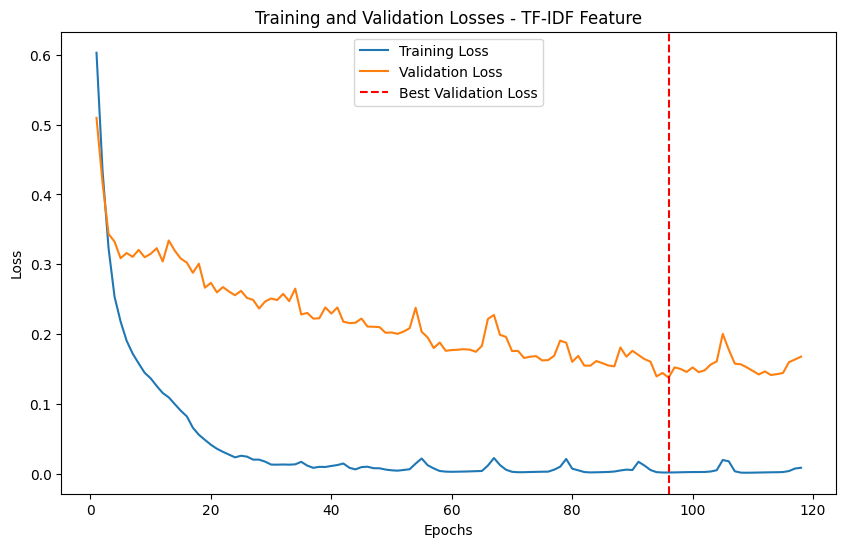

Summary of Metrics:
Accuracy: 0.9628
Precision: 0.9477
Recall: 0.9774
F1-Score: 0.9623
ROC-AUC Score: 0.9917


In [18]:
plot_losses(*tfidf_lstm_losses,'TF-IDF Feature')

evaluate_lstm(tfidf_test_dataset,'TFIDF_LSTM200.pt')

In [31]:

transformer_lstm_losses = train_lstm(transformer_train_dataset,transformer_val_dataset,train_headlines_transformer.shape[1] ,num_epochs=150,early_stop=False, filename='Transformer_LSTM3001.pt')


Epoch 0


100%|██████████| 42/42 [00:00<00:00, 155.50it/s]


Best validation loss: 0.5335949063301086
Model saved
Epoch: 0
	Train Loss:0.6226312792490399
	Validation Loss: 0.5335949063301086
Epoch 1


100%|██████████| 42/42 [00:00<00:00, 162.12it/s]


Best validation loss: 0.42014025222687496
Model saved
Epoch: 1
	Train Loss:0.46849937334893244
	Validation Loss: 0.42014025222687496
Epoch 2


100%|██████████| 42/42 [00:00<00:00, 157.74it/s]


Best validation loss: 0.3520949709983099
Model saved
Epoch: 2
	Train Loss:0.37768675032116117
	Validation Loss: 0.3520949709983099
Epoch 3


100%|██████████| 42/42 [00:00<00:00, 156.96it/s]


Best validation loss: 0.2834527428661074
Model saved
Epoch: 3
	Train Loss:0.3075592366475908
	Validation Loss: 0.2834527428661074
Epoch 4


100%|██████████| 42/42 [00:00<00:00, 159.68it/s]


Best validation loss: 0.23157304951122828
Model saved
Epoch: 4
	Train Loss:0.24090830331283902
	Validation Loss: 0.23157304951122828
Epoch 5


100%|██████████| 42/42 [00:00<00:00, 164.69it/s]


Best validation loss: 0.18809109269863084
Model saved
Epoch: 5
	Train Loss:0.1946151200386267
	Validation Loss: 0.18809109269863084
Epoch 6


100%|██████████| 42/42 [00:00<00:00, 157.01it/s]


Best validation loss: 0.1549382938870362
Model saved
Epoch: 6
	Train Loss:0.15332868299077426
	Validation Loss: 0.1549382938870362
Epoch 7


100%|██████████| 42/42 [00:00<00:00, 159.78it/s]


Best validation loss: 0.13716007130486624
Model saved
Epoch: 7
	Train Loss:0.12891897399510657
	Validation Loss: 0.13716007130486624
Epoch 8


100%|██████████| 42/42 [00:00<00:00, 156.24it/s]


Best validation loss: 0.12742855754636584
Model saved
Epoch: 8
	Train Loss:0.1095230309736161
	Validation Loss: 0.12742855754636584
Epoch 9


100%|██████████| 42/42 [00:00<00:00, 159.78it/s]


Best validation loss: 0.12285476763333593
Model saved
Epoch: 9
	Train Loss:0.09252426187906947
	Validation Loss: 0.12285476763333593
Epoch 10


100%|██████████| 42/42 [00:00<00:00, 158.99it/s]


Best validation loss: 0.09826620056160859
Model saved
Epoch: 10
	Train Loss:0.08177497527665561
	Validation Loss: 0.09826620056160859
Epoch 11


100%|██████████| 42/42 [00:00<00:00, 160.99it/s]


Best validation loss: 0.09327760507308301
Model saved
Epoch: 11
	Train Loss:0.07079608901034272
	Validation Loss: 0.09327760507308301
Epoch 12


100%|██████████| 42/42 [00:00<00:00, 162.70it/s]


Best validation loss: 0.08865092552843548
Model saved
Epoch: 12
	Train Loss:0.06130917667455617
	Validation Loss: 0.08865092552843548
Epoch 13


100%|██████████| 42/42 [00:00<00:00, 152.99it/s]


Best validation loss: 0.08177111253497146
Model saved
Epoch: 13
	Train Loss:0.05280858063922515
	Validation Loss: 0.08177111253497146
Epoch 14


100%|██████████| 42/42 [00:00<00:00, 152.35it/s]


Best validation loss: 0.08162480477421057
Model saved
Epoch: 14
	Train Loss:0.04638794015738226
	Validation Loss: 0.08162480477421057
Epoch 15


100%|██████████| 42/42 [00:00<00:00, 150.27it/s]


Epoch: 15
	Train Loss:0.043897415910448344
	Validation Loss: 0.08645329739721049
Epoch 16


100%|██████████| 42/42 [00:00<00:00, 153.19it/s]


Best validation loss: 0.07656200261165698
Model saved
Epoch: 16
	Train Loss:0.03695294853772909
	Validation Loss: 0.07656200261165698
Epoch 17


100%|██████████| 42/42 [00:00<00:00, 153.37it/s]


Best validation loss: 0.07029086142955791
Model saved
Epoch: 17
	Train Loss:0.03309591046519696
	Validation Loss: 0.07029086142955791
Epoch 18


100%|██████████| 42/42 [00:00<00:00, 143.36it/s]


Epoch: 18
	Train Loss:0.03178868559558713
	Validation Loss: 0.0789512660620468
Epoch 19


100%|██████████| 42/42 [00:00<00:00, 144.79it/s]


Best validation loss: 0.0699465401204569
Model saved
Epoch: 19
	Train Loss:0.02886594445370729
	Validation Loss: 0.0699465401204569
Epoch 20


100%|██████████| 42/42 [00:00<00:00, 145.54it/s]


Epoch: 20
	Train Loss:0.02415639663203841
	Validation Loss: 0.0714787014183544
Epoch 21


100%|██████████| 42/42 [00:00<00:00, 141.10it/s]


Best validation loss: 0.06967141887261755
Model saved
Epoch: 21
	Train Loss:0.022163040902731673
	Validation Loss: 0.06967141887261755
Epoch 22


100%|██████████| 42/42 [00:00<00:00, 131.61it/s]


Best validation loss: 0.06729462494452794
Model saved
Epoch: 22
	Train Loss:0.019887811171689203
	Validation Loss: 0.06729462494452794
Epoch 23


100%|██████████| 42/42 [00:00<00:00, 132.01it/s]


Best validation loss: 0.06292025642913013
Model saved
Epoch: 23
	Train Loss:0.01853159721940756
	Validation Loss: 0.06292025642913013
Epoch 24


100%|██████████| 42/42 [00:00<00:00, 133.90it/s]


Epoch: 24
	Train Loss:0.01694898133439618
	Validation Loss: 0.06653942753161703
Epoch 25


100%|██████████| 42/42 [00:00<00:00, 135.65it/s]


Epoch: 25
	Train Loss:0.01471349001226444
	Validation Loss: 0.070593077290271
Epoch 26


100%|██████████| 42/42 [00:00<00:00, 137.17it/s]


Epoch: 26
	Train Loss:0.015028837528671063
	Validation Loss: 0.06713791776980672
Epoch 27


100%|██████████| 42/42 [00:00<00:00, 139.28it/s]


Epoch: 27
	Train Loss:0.014239100510224936
	Validation Loss: 0.06648230645805597
Epoch 28


100%|██████████| 42/42 [00:00<00:00, 137.77it/s]


Best validation loss: 0.059662810615485624
Model saved
Epoch: 28
	Train Loss:0.011856380646811828
	Validation Loss: 0.059662810615485624
Epoch 29


100%|██████████| 42/42 [00:00<00:00, 137.70it/s]


Epoch: 29
	Train Loss:0.010972665417717681
	Validation Loss: 0.06461688769715172
Epoch 30


100%|██████████| 42/42 [00:00<00:00, 135.74it/s]


Epoch: 30
	Train Loss:0.011951785246353774
	Validation Loss: 0.0675752097075539
Epoch 31


100%|██████████| 42/42 [00:00<00:00, 136.71it/s]


Epoch: 31
	Train Loss:0.00963891144391031
	Validation Loss: 0.06228353311529472
Epoch 32


100%|██████████| 42/42 [00:00<00:00, 136.03it/s]


Epoch: 32
	Train Loss:0.01125540965724559
	Validation Loss: 0.06689173435526234
Epoch 33


100%|██████████| 42/42 [00:00<00:00, 139.33it/s]


Epoch: 33
	Train Loss:0.010293720484090349
	Validation Loss: 0.06079389165998215
Epoch 34


100%|██████████| 42/42 [00:00<00:00, 136.86it/s]


Epoch: 34
	Train Loss:0.008563677464345736
	Validation Loss: 0.06786955791037708
Epoch 35


100%|██████████| 42/42 [00:00<00:00, 141.58it/s]


Epoch: 35
	Train Loss:0.007946921882057001
	Validation Loss: 0.07051579711870068
Epoch 36


100%|██████████| 42/42 [00:00<00:00, 146.03it/s]


Epoch: 36
	Train Loss:0.007608995941053662
	Validation Loss: 0.07700389036021772
Epoch 37


100%|██████████| 42/42 [00:00<00:00, 138.80it/s]


Epoch: 37
	Train Loss:0.008225997107931309
	Validation Loss: 0.06075057119042391
Epoch 38


100%|██████████| 42/42 [00:00<00:00, 133.74it/s]


Best validation loss: 0.05712407865073709
Model saved
Epoch: 38
	Train Loss:0.007268713546975974
	Validation Loss: 0.05712407865073709
Epoch 39


100%|██████████| 42/42 [00:00<00:00, 136.56it/s]


Epoch: 39
	Train Loss:0.006026248364443225
	Validation Loss: 0.06325042386361886
Epoch 40


100%|██████████| 42/42 [00:00<00:00, 150.81it/s]


Epoch: 40
	Train Loss:0.010054368664333154
	Validation Loss: 0.06583818959604416
Epoch 41


100%|██████████| 42/42 [00:00<00:00, 153.84it/s]


Epoch: 41
	Train Loss:0.012922798300028912
	Validation Loss: 0.05946460017003119
Epoch 42


100%|██████████| 42/42 [00:00<00:00, 151.72it/s]


Epoch: 42
	Train Loss:0.006500050216721046
	Validation Loss: 0.05995819973759353
Epoch 43


100%|██████████| 42/42 [00:00<00:00, 157.06it/s]


Epoch: 43
	Train Loss:0.004651308991014957
	Validation Loss: 0.05993993997219063
Epoch 44


100%|██████████| 42/42 [00:00<00:00, 153.26it/s]


Epoch: 44
	Train Loss:0.004652303320148753
	Validation Loss: 0.061192160937935114
Epoch 45


100%|██████████| 42/42 [00:00<00:00, 153.62it/s]


Best validation loss: 0.05415952226723589
Model saved
Epoch: 45
	Train Loss:0.004376571846290654
	Validation Loss: 0.05415952226723589
Epoch 46


100%|██████████| 42/42 [00:00<00:00, 158.09it/s]


Epoch: 46
	Train Loss:0.0070385266638671356
	Validation Loss: 0.0643382202390404
Epoch 47


100%|██████████| 42/42 [00:00<00:00, 158.02it/s]


Best validation loss: 0.05280203213693485
Model saved
Epoch: 47
	Train Loss:0.006029079507459842
	Validation Loss: 0.05280203213693485
Epoch 48


100%|██████████| 42/42 [00:00<00:00, 158.98it/s]


Epoch: 48
	Train Loss:0.006558043139410161
	Validation Loss: 0.0700784764319126
Epoch 49


100%|██████████| 42/42 [00:00<00:00, 151.65it/s]


Epoch: 49
	Train Loss:0.005885060923728382
	Validation Loss: 0.07594096474349499
Epoch 50


100%|██████████| 42/42 [00:00<00:00, 159.62it/s]


Epoch: 50
	Train Loss:0.00700564180049927
	Validation Loss: 0.057522754539691266
Epoch 51


100%|██████████| 42/42 [00:00<00:00, 160.44it/s]


Best validation loss: 0.048829748638949934
Model saved
Epoch: 51
	Train Loss:0.003749844097044496
	Validation Loss: 0.048829748638949934
Epoch 52


100%|██████████| 42/42 [00:00<00:00, 160.87it/s]


Epoch: 52
	Train Loss:0.0034230290570237214
	Validation Loss: 0.05024782760024425
Epoch 53


100%|██████████| 42/42 [00:00<00:00, 157.52it/s]


Epoch: 53
	Train Loss:0.003447902159735797
	Validation Loss: 0.05378984017962856
Epoch 54


100%|██████████| 42/42 [00:00<00:00, 158.08it/s]


Epoch: 54
	Train Loss:0.005698278928840799
	Validation Loss: 0.07097658230036143
Epoch 55


100%|██████████| 42/42 [00:00<00:00, 161.21it/s]


Epoch: 55
	Train Loss:0.018282515556728912
	Validation Loss: 0.0873241810394185
Epoch 56


100%|██████████| 42/42 [00:00<00:00, 160.33it/s]


Epoch: 56
	Train Loss:0.0059715950619503265
	Validation Loss: 0.05856476422576677
Epoch 57


100%|██████████| 42/42 [00:00<00:00, 164.49it/s]


Epoch: 57
	Train Loss:0.0037340822274841015
	Validation Loss: 0.05846286486346452
Epoch 58


100%|██████████| 42/42 [00:00<00:00, 142.58it/s]


Epoch: 58
	Train Loss:0.002651035529746127
	Validation Loss: 0.05033797740803233
Epoch 59


100%|██████████| 42/42 [00:00<00:00, 151.33it/s]


Epoch: 59
	Train Loss:0.0027200928602796343
	Validation Loss: 0.06739164754703995
Epoch 60


100%|██████████| 42/42 [00:00<00:00, 152.51it/s]


Epoch: 60
	Train Loss:0.0028363720999868025
	Validation Loss: 0.0493397953964415
Epoch 61


100%|██████████| 42/42 [00:00<00:00, 145.83it/s]


Epoch: 61
	Train Loss:0.002757097152800905
	Validation Loss: 0.05311742839625194
Epoch 62


100%|██████████| 42/42 [00:00<00:00, 147.22it/s]


Epoch: 62
	Train Loss:0.0037043844820887203
	Validation Loss: 0.06313994912696737
Epoch 63


100%|██████████| 42/42 [00:00<00:00, 146.82it/s]


Epoch: 63
	Train Loss:0.0035089238062648784
	Validation Loss: 0.05133102932346186
Epoch 64


100%|██████████| 42/42 [00:00<00:00, 149.91it/s]


Epoch: 64
	Train Loss:0.005741679503227628
	Validation Loss: 0.06810027697966212
Epoch 65


100%|██████████| 42/42 [00:00<00:00, 146.39it/s]


Epoch: 65
	Train Loss:0.013716965502623232
	Validation Loss: 0.05176272800946165
Epoch 66


100%|██████████| 42/42 [00:00<00:00, 135.26it/s]


Best validation loss: 0.04781926615673694
Model saved
Epoch: 66
	Train Loss:0.007700036955250811
	Validation Loss: 0.04781926615673694
Epoch 67


100%|██████████| 42/42 [00:00<00:00, 133.65it/s]


Epoch: 67
	Train Loss:0.002864067860794002
	Validation Loss: 0.053151025653018484
Epoch 68


100%|██████████| 42/42 [00:00<00:00, 132.94it/s]


Epoch: 68
	Train Loss:0.0020438216955563616
	Validation Loss: 0.04948967013375035
Epoch 69


100%|██████████| 42/42 [00:00<00:00, 134.29it/s]


Epoch: 69
	Train Loss:0.001920220680490491
	Validation Loss: 0.04852927888610533
Epoch 70


100%|██████████| 42/42 [00:00<00:00, 136.26it/s]


Epoch: 70
	Train Loss:0.0020934073540884706
	Validation Loss: 0.05195951478422752
Epoch 71


100%|██████████| 42/42 [00:00<00:00, 134.74it/s]


Epoch: 71
	Train Loss:0.002247803609833003
	Validation Loss: 0.05134261339636786
Epoch 72


100%|██████████| 42/42 [00:00<00:00, 140.45it/s]


Epoch: 72
	Train Loss:0.002222424905214991
	Validation Loss: 0.04969658420997716
Epoch 73


100%|██████████| 42/42 [00:00<00:00, 136.87it/s]


Epoch: 73
	Train Loss:0.0025922152359733387
	Validation Loss: 0.05143291679477053
Epoch 74


100%|██████████| 42/42 [00:00<00:00, 133.35it/s]


Epoch: 74
	Train Loss:0.0025690072396260108
	Validation Loss: 0.048422555782876554
Epoch 75


100%|██████████| 42/42 [00:00<00:00, 136.10it/s]


Epoch: 75
	Train Loss:0.0031217572478843586
	Validation Loss: 0.05535951517300591
Epoch 76


100%|██████████| 42/42 [00:00<00:00, 139.99it/s]


Epoch: 76
	Train Loss:0.0034202253233478774
	Validation Loss: 0.050881897853243915
Epoch 77


100%|██████████| 42/42 [00:00<00:00, 139.64it/s]


Epoch: 77
	Train Loss:0.007910443216724882
	Validation Loss: 0.10843572617020636
Epoch 78


100%|██████████| 42/42 [00:00<00:00, 137.05it/s]


Epoch: 78
	Train Loss:0.024840771080186917
	Validation Loss: 0.06735305991467266
Epoch 79


100%|██████████| 42/42 [00:00<00:00, 138.84it/s]


Best validation loss: 0.043171467869320794
Model saved
Epoch: 79
	Train Loss:0.0048598771723586
	Validation Loss: 0.043171467869320794
Epoch 80


100%|██████████| 42/42 [00:00<00:00, 135.05it/s]


Epoch: 80
	Train Loss:0.0021978772512363594
	Validation Loss: 0.045341627359101994
Epoch 81


100%|██████████| 42/42 [00:00<00:00, 131.50it/s]


Epoch: 81
	Train Loss:0.0018856481936324152
	Validation Loss: 0.04393293300000507
Epoch 82


100%|██████████| 42/42 [00:00<00:00, 149.97it/s]


Best validation loss: 0.04114093151985712
Model saved
Epoch: 82
	Train Loss:0.0016653369608638246
	Validation Loss: 0.04114093151985712
Epoch 83


100%|██████████| 42/42 [00:00<00:00, 153.78it/s]


Epoch: 83
	Train Loss:0.002571034147718271
	Validation Loss: 0.05124114589056089
Epoch 84


100%|██████████| 42/42 [00:00<00:00, 158.00it/s]


Epoch: 84
	Train Loss:0.0019440952871393944
	Validation Loss: 0.044920917184624286
Epoch 85


100%|██████████| 42/42 [00:00<00:00, 153.78it/s]


Epoch: 85
	Train Loss:0.0023455622703916143
	Validation Loss: 0.049125188684445764
Epoch 86


100%|██████████| 42/42 [00:00<00:00, 162.10it/s]


Epoch: 86
	Train Loss:0.001939882260529206
	Validation Loss: 0.05241059803492611
Epoch 87


100%|██████████| 42/42 [00:00<00:00, 161.96it/s]


Epoch: 87
	Train Loss:0.00207981043439802
	Validation Loss: 0.052763643147911696
Epoch 88


100%|██████████| 42/42 [00:00<00:00, 161.08it/s]


Epoch: 88
	Train Loss:0.0020105539731466995
	Validation Loss: 0.04387028247029299
Epoch 89


100%|██████████| 42/42 [00:00<00:00, 161.15it/s]


Epoch: 89
	Train Loss:0.0024419817325126913
	Validation Loss: 0.046073399062844966
Epoch 90


100%|██████████| 42/42 [00:00<00:00, 162.24it/s]


Epoch: 90
	Train Loss:0.0020842861826716377
	Validation Loss: 0.04557829965016849
Epoch 91


100%|██████████| 42/42 [00:00<00:00, 162.01it/s]


Epoch: 91
	Train Loss:0.0022469572131595915
	Validation Loss: 0.048753886605568585
Epoch 92


100%|██████████| 42/42 [00:00<00:00, 164.43it/s]


Epoch: 92
	Train Loss:0.0021950082353589732
	Validation Loss: 0.04746280446471203
Epoch 93


100%|██████████| 42/42 [00:00<00:00, 159.75it/s]


Epoch: 93
	Train Loss:0.00803077114202703
	Validation Loss: 0.07386958377347105
Epoch 94


100%|██████████| 42/42 [00:00<00:00, 153.43it/s]


Epoch: 94
	Train Loss:0.009833499281075858
	Validation Loss: 0.05386791012937292
Epoch 95


100%|██████████| 42/42 [00:00<00:00, 154.60it/s]


Epoch: 95
	Train Loss:0.004459425088180791
	Validation Loss: 0.058849576771968885
Epoch 96


100%|██████████| 42/42 [00:00<00:00, 157.55it/s]


Epoch: 96
	Train Loss:0.0027571513496768025
	Validation Loss: 0.04191670920478091
Epoch 97


100%|██████████| 42/42 [00:00<00:00, 155.86it/s]


Epoch: 97
	Train Loss:0.006519419206712868
	Validation Loss: 0.04884763426768283
Epoch 98


100%|██████████| 42/42 [00:00<00:00, 143.13it/s]


Epoch: 98
	Train Loss:0.0029961538629510276
	Validation Loss: 0.045818171078627484
Epoch 99


100%|██████████| 42/42 [00:00<00:00, 145.25it/s]


Epoch: 99
	Train Loss:0.0014492827527675897
	Validation Loss: 0.046392052417754064
Epoch 100


100%|██████████| 42/42 [00:00<00:00, 145.03it/s]


Epoch: 100
	Train Loss:0.0013607733957802079
	Validation Loss: 0.04188992110513417
Epoch 101


100%|██████████| 42/42 [00:00<00:00, 142.43it/s]


Epoch: 101
	Train Loss:0.0014588773816025683
	Validation Loss: 0.04463008125977857
Epoch 102


100%|██████████| 42/42 [00:00<00:00, 141.45it/s]


Epoch: 102
	Train Loss:0.0015990762423450453
	Validation Loss: 0.04253670808282636
Epoch 103


100%|██████████| 42/42 [00:00<00:00, 143.30it/s]


Epoch: 103
	Train Loss:0.0018150972845476297
	Validation Loss: 0.054986957859780104
Epoch 104


100%|██████████| 42/42 [00:00<00:00, 142.52it/s]


Epoch: 104
	Train Loss:0.0018458522912595302
	Validation Loss: 0.044505868716875
Epoch 105


100%|██████████| 42/42 [00:00<00:00, 132.24it/s]


Epoch: 105
	Train Loss:0.0018317947775820299
	Validation Loss: 0.04585672498104118
Epoch 106


100%|██████████| 42/42 [00:00<00:00, 143.33it/s]


Best validation loss: 0.039904331433631125
Model saved
Epoch: 106
	Train Loss:0.002081157991640447
	Validation Loss: 0.039904331433631125
Epoch 107


100%|██████████| 42/42 [00:00<00:00, 133.75it/s]


Epoch: 107
	Train Loss:0.010871715164588144
	Validation Loss: 0.09037528295690815
Epoch 108


100%|██████████| 42/42 [00:00<00:00, 134.21it/s]


Epoch: 108
	Train Loss:0.014722527289349172
	Validation Loss: 0.05609964452395659
Epoch 109


100%|██████████| 42/42 [00:00<00:00, 131.45it/s]


Epoch: 109
	Train Loss:0.002628837705641571
	Validation Loss: 0.05376834015173483
Epoch 110


100%|██████████| 42/42 [00:00<00:00, 136.28it/s]


Epoch: 110
	Train Loss:0.0014664622433465122
	Validation Loss: 0.04590600479527244
Epoch 111


100%|██████████| 42/42 [00:00<00:00, 131.80it/s]


Epoch: 111
	Train Loss:0.0013466480022688056
	Validation Loss: 0.04406038321931625
Epoch 112


100%|██████████| 42/42 [00:00<00:00, 136.05it/s]


Epoch: 112
	Train Loss:0.001334186839235444
	Validation Loss: 0.04279287120083436
Epoch 113


100%|██████████| 42/42 [00:00<00:00, 141.83it/s]


Epoch: 113
	Train Loss:0.0013811236680744009
	Validation Loss: 0.04225114574156968
Epoch 114


100%|██████████| 42/42 [00:00<00:00, 134.43it/s]


Epoch: 114
	Train Loss:0.0015001061722628832
	Validation Loss: 0.04262015408104552
Epoch 115


100%|██████████| 42/42 [00:00<00:00, 135.57it/s]


Epoch: 115
	Train Loss:0.0015408333052792365
	Validation Loss: 0.04438347180396141
Epoch 116


100%|██████████| 42/42 [00:00<00:00, 136.62it/s]


Epoch: 116
	Train Loss:0.0016262713646043152
	Validation Loss: 0.0423667958848888
Epoch 117


100%|██████████| 42/42 [00:00<00:00, 133.68it/s]


Epoch: 117
	Train Loss:0.001685280467860312
	Validation Loss: 0.04253912291633675
Epoch 118


100%|██████████| 42/42 [00:00<00:00, 132.78it/s]


Epoch: 118
	Train Loss:0.0017653664792074808
	Validation Loss: 0.04179261734576097
Epoch 119


100%|██████████| 42/42 [00:00<00:00, 133.68it/s]


Epoch: 119
	Train Loss:0.0018205944645506818
	Validation Loss: 0.04661981571864869
Epoch 120


100%|██████████| 42/42 [00:00<00:00, 134.67it/s]


Epoch: 120
	Train Loss:0.0017886464423980445
	Validation Loss: 0.04504362629571309
Epoch 121


100%|██████████| 42/42 [00:00<00:00, 134.38it/s]


Epoch: 121
	Train Loss:0.0020428833621923648
	Validation Loss: 0.04362911449944867
Epoch 122


100%|██████████| 42/42 [00:00<00:00, 137.74it/s]


Epoch: 122
	Train Loss:0.0020536954065651764
	Validation Loss: 0.05072177547429289
Epoch 123


100%|██████████| 42/42 [00:00<00:00, 136.50it/s]


Epoch: 123
	Train Loss:0.002340043922664509
	Validation Loss: 0.04447154787236026
Epoch 124


100%|██████████| 42/42 [00:00<00:00, 136.18it/s]


Epoch: 124
	Train Loss:0.023201643389516642
	Validation Loss: 0.05558440874197653
Epoch 125


100%|██████████| 42/42 [00:00<00:00, 153.31it/s]


Best validation loss: 0.03720604635531172
Model saved
Epoch: 125
	Train Loss:0.004748653204250519
	Validation Loss: 0.03720604635531172
Epoch 126


100%|██████████| 42/42 [00:00<00:00, 162.86it/s]


Epoch: 126
	Train Loss:0.0017410623044097086
	Validation Loss: 0.04436957718349904
Epoch 127


100%|██████████| 42/42 [00:00<00:00, 159.40it/s]


Epoch: 127
	Train Loss:0.001241899167080336
	Validation Loss: 0.038780285264476244
Epoch 128


100%|██████████| 42/42 [00:00<00:00, 158.22it/s]


Epoch: 128
	Train Loss:0.0012098182937950782
	Validation Loss: 0.04213334301242694
Epoch 129


100%|██████████| 42/42 [00:00<00:00, 158.08it/s]


Epoch: 129
	Train Loss:0.0012645144717738268
	Validation Loss: 0.04120679992428493
Epoch 130


100%|██████████| 42/42 [00:00<00:00, 153.51it/s]


Epoch: 130
	Train Loss:0.0013085244411033476
	Validation Loss: 0.042968869170484446
Epoch 131


100%|██████████| 42/42 [00:00<00:00, 154.26it/s]


Epoch: 131
	Train Loss:0.0013671422863216509
	Validation Loss: 0.041624251797440504
Epoch 132


100%|██████████| 42/42 [00:00<00:00, 157.73it/s]


Epoch: 132
	Train Loss:0.0013782677244365451
	Validation Loss: 0.040924536978958974
Epoch 133


100%|██████████| 42/42 [00:00<00:00, 164.84it/s]


Epoch: 133
	Train Loss:0.0014656828000350662
	Validation Loss: 0.03826118511469325
Epoch 134


100%|██████████| 42/42 [00:00<00:00, 161.87it/s]


Epoch: 134
	Train Loss:0.0016541537350147134
	Validation Loss: 0.03968045729423119
Epoch 135


100%|██████████| 42/42 [00:00<00:00, 159.95it/s]


Epoch: 135
	Train Loss:0.0016281855909804266
	Validation Loss: 0.039265869556748795
Epoch 136


100%|██████████| 42/42 [00:00<00:00, 154.12it/s]


Epoch: 136
	Train Loss:0.0017139814181497232
	Validation Loss: 0.04653337600341599
Epoch 137


100%|██████████| 42/42 [00:00<00:00, 159.20it/s]


Epoch: 137
	Train Loss:0.0017295064005468572
	Validation Loss: 0.04321197362150997
Epoch 138


100%|██████████| 42/42 [00:00<00:00, 158.65it/s]


Epoch: 138
	Train Loss:0.0021310714544684048
	Validation Loss: 0.03862360401433848
Epoch 139


100%|██████████| 42/42 [00:00<00:00, 146.28it/s]


Epoch: 139
	Train Loss:0.013804770128372761
	Validation Loss: 0.048536973897301196
Epoch 140


100%|██████████| 42/42 [00:00<00:00, 147.73it/s]


Epoch: 140
	Train Loss:0.0037299516640367015
	Validation Loss: 0.039284896557330196
Epoch 141


100%|██████████| 42/42 [00:00<00:00, 144.40it/s]


Epoch: 141
	Train Loss:0.0014938603615894587
	Validation Loss: 0.04152032460219094
Epoch 142


100%|██████████| 42/42 [00:00<00:00, 149.33it/s]


Epoch: 142
	Train Loss:0.0012158293342624334
	Validation Loss: 0.0391323273735387
Epoch 143


100%|██████████| 42/42 [00:00<00:00, 145.32it/s]


Epoch: 143
	Train Loss:0.0012043790350342908
	Validation Loss: 0.04296585261112168
Epoch 144


100%|██████████| 42/42 [00:00<00:00, 145.77it/s]


Epoch: 144
	Train Loss:0.0013110112437667947
	Validation Loss: 0.04369770434485482
Epoch 145


100%|██████████| 42/42 [00:00<00:00, 144.20it/s]


Epoch: 145
	Train Loss:0.0013360630823410161
	Validation Loss: 0.04085902321163476
Epoch 146


100%|██████████| 42/42 [00:00<00:00, 148.12it/s]


Epoch: 146
	Train Loss:0.001419650977440474
	Validation Loss: 0.043744125248243414
Epoch 147


100%|██████████| 42/42 [00:00<00:00, 144.15it/s]


Epoch: 147
	Train Loss:0.0014481203277624908
	Validation Loss: 0.040376355890960745
Epoch 148


100%|██████████| 42/42 [00:00<00:00, 136.26it/s]


Epoch: 148
	Train Loss:0.0015196112887231662
	Validation Loss: 0.040283845022453794
Epoch 149


100%|██████████| 42/42 [00:00<00:00, 136.10it/s]

Epoch: 149
	Train Loss:0.0016321556943853105
	Validation Loss: 0.04367874302191749


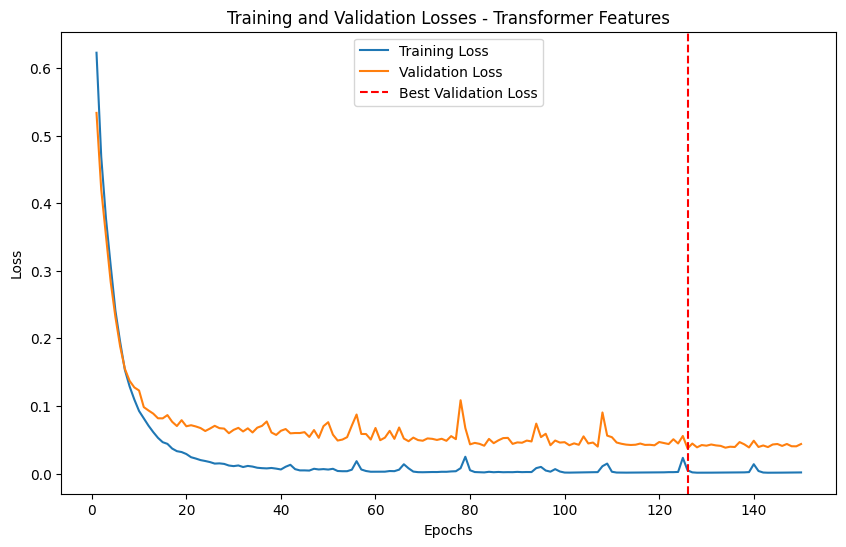

Summary of Metrics:
Accuracy: 0.9907
Precision: 0.9823
Recall: 0.9989
F1-Score: 0.9905
ROC-AUC Score: 0.9996


In [33]:
plot_losses(*transformer_lstm_losses,'Transformer Features')
evaluate_lstm(transformer_test_dataset,'Transformer_LSTM3001.pt')

In [20]:
from torch.utils.data import TensorDataset


#Encode labels for multiclass
le = LabelEncoder()
y_train_encoded=le.fit_transform(Y_train)
y_val_encoded=le.transform(Y_val)
y_test_encoded=le.transform(Y_test)


#Predict related for train and val
def predict_related(dataset):
    related_model = LSTM(384, 512,1).to(device)
    related_model.load_state_dict(torch.load('Transformer_LSTM3001.pt'))
    related_model.eval()

    texts,stances= next(iter(DataLoader(dataset,batch_size=len(dataset),shuffle=False)))
    stances=stances.to(device)
    with torch.no_grad():
        related_output = related_model(texts)
        related_probabilities=torch.sigmoid(related_output).cpu().numpy().tolist()
        related_predictions=(np.array(related_probabilities) > 0.5).astype(int)
    predicted_indices = np.array(np.where(related_predictions==1))[0]
    actual_indices = np.array(np.where(stances.cpu()!=3))[0]
    related_indices= torch.tensor(np.intersect1d(predicted_indices, actual_indices, assume_unique=True)).to(device)
    related_indices=torch.tensor(actual_indices).to(device)
    related_texts = torch.index_select(texts,0,related_indices)
    related_stances = torch.index_select(stances,0,related_indices)
    
    return related_texts, related_stances
    
train_dataset=TransformerDataset(train_headlines_transformer, train_bodies_transformer,y_train_encoded)
val_dataset = TransformerDataset(val_headlines_transformer, val_bodies_transformer,y_val_encoded)
test_dataset= TransformerDataset(test_headlines_transformer, test_bodies_transformer,y_test_encoded)

stance_train_dataset=TensorDataset(*predict_related(train_dataset))
stance_val_dataset=TensorDataset(*predict_related(val_dataset))
stance_test_dataset=TensorDataset(*predict_related(test_dataset))
stances_losses=[]

print('Training set size',len(stance_train_dataset))
print('Validation set size',len(stance_val_dataset))
print('Test set size',len(stance_test_dataset))




Training set size 8109
Validation set size 2706
Test set size 2612


In [9]:
class GRUModel(nn.Module):
    def __init__(self,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 dropout):
        
        super().__init__()
        self.model = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          batch_first = True,
                          dropout = dropout)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        _, hidden = self.model(text)
        
        hidden = self.dropout(hidden[-1,:,:])
                
        output = self.out(hidden)
        return output


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters 
num_epochs = 300
learning_rate = 0.01
batch_size=32

hidden_dim = 128
num_layers=3
dropout_rate=0.2


early_stop=False
output_dim = 3



stance_train_loader = DataLoader(stance_train_dataset,batch_size=batch_size,shuffle=True)
stance_val_loader = DataLoader(stance_val_dataset , batch_size = batch_size , shuffle=False)



#Model to classify into agree
stance_model=GRUModel(train_headlines_transformer.shape[1],hidden_dim,output_dim,num_layers,dropout_rate)
stance_model=stance_model.to(device)


criterion = nn.CrossEntropyLoss()
criterion=criterion.to(device)
optimizer = torch.optim.Adam(stance_model.parameters(), lr=learning_rate, weight_decay=1e-5)  
train_losses=[]
val_losses=[]
best_val_loss=float('inf')

best_val_epoch=0
for epoch in range(num_epochs):
    epoch_loss=0
    val_epoch_loss=0
    print(f'Epoch {epoch}')
    stance_model.train()
    print(stance_model.training)
    for i, (text, stance) in enumerate(tqdm(stance_train_loader)):  
        stance=stance.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        # Forward pass            
        stance_predictions = stance_model(text)
        

        # Calculate loss
        loss = criterion(stance_predictions, stance)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_loss= epoch_loss/len(stance_train_loader)


    stance_model.eval()
    with torch.no_grad():
        for i, (text,stance) in enumerate(tqdm(stance_val_loader)):
            stance=stance.type(torch.LongTensor).to(device)
            stance_predictions = stance_model(text)
            # Calculate loss
            loss = criterion(stance_predictions, stance)

            val_epoch_loss+=loss.item()

        val_loss = val_epoch_loss / len(stance_val_loader)

        if val_loss<best_val_loss:
            best_val_loss = val_loss
            best_val_epoch=epoch
            torch.save(stance_model.state_dict(), 'Stance_Model.pt')
            print(f'Best validation loss: {val_loss}')
            print('Model saved')
            loss_increase_counter=0
        elif val_loss-last<0 and loss_increase_counter>0:
            loss_increase_counter-=1
        elif early_stop:
            loss_increase_counter+=1


    print(f'Epoch: {epoch}')
    print(f'\tTrain Loss:{train_loss}')
    print(f'\tValidation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    last=val_loss
    if loss_increase_counter>10:
        print("Model stopped early at epoch ",epoch)
        break

print('Best validation loss:',best_val_loss)


Epoch 0
True


100%|██████████| 85/85 [00:00<00:00, 1067.23it/s]


Best validation loss: 0.5960568312336417
Model saved
Epoch: 0
	Train Loss:0.6712119750619874
	Validation Loss: 0.5960568312336417
Epoch 1
True


100%|██████████| 85/85 [00:00<00:00, 1056.32it/s]


Best validation loss: 0.5673478403512169
Model saved
Epoch: 1
	Train Loss:0.58023455216894
	Validation Loss: 0.5673478403512169
Epoch 2
True


100%|██████████| 85/85 [00:00<00:00, 1073.47it/s]


Best validation loss: 0.5090232470456292
Model saved
Epoch: 2
	Train Loss:0.5366239230933152
	Validation Loss: 0.5090232470456292
Epoch 3
True


100%|██████████| 85/85 [00:00<00:00, 1071.23it/s]


Best validation loss: 0.4946560801828609
Model saved
Epoch: 3
	Train Loss:0.49837955938080164
	Validation Loss: 0.4946560801828609
Epoch 4
True


100%|██████████| 85/85 [00:00<00:00, 1085.82it/s]


Best validation loss: 0.466804768408046
Model saved
Epoch: 4
	Train Loss:0.4589666220850832
	Validation Loss: 0.466804768408046
Epoch 5
True


100%|██████████| 85/85 [00:00<00:00, 1091.65it/s]


Best validation loss: 0.42638824021115024
Model saved
Epoch: 5
	Train Loss:0.42895008465201834
	Validation Loss: 0.42638824021115024
Epoch 6
True


100%|██████████| 85/85 [00:00<00:00, 1079.93it/s]


Epoch: 6
	Train Loss:0.3870385336711651
	Validation Loss: 0.4360689803957939
Epoch 7
True


100%|██████████| 85/85 [00:00<00:00, 1060.67it/s]


Best validation loss: 0.39983671368921503
Model saved
Epoch: 7
	Train Loss:0.3600309718194909
	Validation Loss: 0.39983671368921503
Epoch 8
True


100%|██████████| 85/85 [00:00<00:00, 1072.95it/s]


Epoch: 8
	Train Loss:0.3340292629001178
	Validation Loss: 0.4002559532137478
Epoch 9
True


100%|██████████| 85/85 [00:00<00:00, 1072.73it/s]


Best validation loss: 0.3697492613511927
Model saved
Epoch: 9
	Train Loss:0.30804688354411464
	Validation Loss: 0.3697492613511927
Epoch 10
True


100%|██████████| 85/85 [00:00<00:00, 1052.17it/s]


Best validation loss: 0.298064020013108
Model saved
Epoch: 10
	Train Loss:0.2828598881331016
	Validation Loss: 0.298064020013108
Epoch 11
True


100%|██████████| 85/85 [00:00<00:00, 1080.40it/s]


Best validation loss: 0.28250469188479815
Model saved
Epoch: 11
	Train Loss:0.25963813707408473
	Validation Loss: 0.28250469188479815
Epoch 12
True


100%|██████████| 85/85 [00:00<00:00, 1061.11it/s]


Epoch: 12
	Train Loss:0.22115650729048908
	Validation Loss: 0.32053813053404584
Epoch 13
True


100%|██████████| 85/85 [00:00<00:00, 1046.76it/s]


Best validation loss: 0.27734241216059996
Model saved
Epoch: 13
	Train Loss:0.20839760610173771
	Validation Loss: 0.27734241216059996
Epoch 14
True


100%|██████████| 85/85 [00:00<00:00, 1053.71it/s]


Best validation loss: 0.2701310687862775
Model saved
Epoch: 14
	Train Loss:0.19595953823602574
	Validation Loss: 0.2701310687862775
Epoch 15
True


100%|██████████| 85/85 [00:00<00:00, 1060.09it/s]


Best validation loss: 0.22654203229090747
Model saved
Epoch: 15
	Train Loss:0.17437787082662262
	Validation Loss: 0.22654203229090747
Epoch 16
True


100%|██████████| 85/85 [00:00<00:00, 1019.17it/s]


Epoch: 16
	Train Loss:0.1613314227773038
	Validation Loss: 0.263371884800932
Epoch 17
True


100%|██████████| 85/85 [00:00<00:00, 941.93it/s]


Epoch: 17
	Train Loss:0.13894947527313795
	Validation Loss: 0.26755306152079034
Epoch 18
True


100%|██████████| 85/85 [00:00<00:00, 1050.35it/s]


Best validation loss: 0.2004953563761185
Model saved
Epoch: 18
	Train Loss:0.1401832544604155
	Validation Loss: 0.2004953563761185
Epoch 19
True


100%|██████████| 85/85 [00:00<00:00, 1043.96it/s]


Epoch: 19
	Train Loss:0.13415685383324313
	Validation Loss: 0.21657613934401204
Epoch 20
True


100%|██████████| 85/85 [00:00<00:00, 1034.50it/s]


Best validation loss: 0.17387574741288142
Model saved
Epoch: 20
	Train Loss:0.13098876918556066
	Validation Loss: 0.17387574741288142
Epoch 21
True


100%|██████████| 85/85 [00:00<00:00, 1060.85it/s]


Epoch: 21
	Train Loss:0.10975959666410652
	Validation Loss: 0.2109133946654551
Epoch 22
True


100%|██████████| 85/85 [00:00<00:00, 1067.06it/s]


Epoch: 22
	Train Loss:0.11512914813842302
	Validation Loss: 0.20093530849005808
Epoch 23
True


100%|██████████| 85/85 [00:00<00:00, 1053.37it/s]


Epoch: 23
	Train Loss:0.10397612015298736
	Validation Loss: 0.23488240636446897
Epoch 24
True


100%|██████████| 85/85 [00:00<00:00, 1071.37it/s]


Epoch: 24
	Train Loss:0.11096035404035484
	Validation Loss: 0.18853697134181857
Epoch 25
True


100%|██████████| 85/85 [00:00<00:00, 1050.36it/s]


Epoch: 25
	Train Loss:0.10199847450025204
	Validation Loss: 0.2080089772996657
Epoch 26
True


100%|██████████| 85/85 [00:00<00:00, 1051.96it/s]


Epoch: 26
	Train Loss:0.10580314564386632
	Validation Loss: 0.2287454423001584
Epoch 27
True


100%|██████████| 85/85 [00:00<00:00, 1041.10it/s]


Epoch: 27
	Train Loss:0.09685928284146596
	Validation Loss: 0.17772120276246878
Epoch 28
True


100%|██████████| 85/85 [00:00<00:00, 1054.36it/s]


Epoch: 28
	Train Loss:0.09059311006141196
	Validation Loss: 0.23249142917475718
Epoch 29
True


100%|██████████| 85/85 [00:00<00:00, 1065.40it/s]


Epoch: 29
	Train Loss:0.10272247580936046
	Validation Loss: 0.20707709551514947
Epoch 30
True


100%|██████████| 85/85 [00:00<00:00, 1059.99it/s]


Epoch: 30
	Train Loss:0.0858576801114195
	Validation Loss: 0.2243214866913417
Epoch 31
True


100%|██████████| 85/85 [00:00<00:00, 1070.50it/s]


Epoch: 31
	Train Loss:0.08335265560775966
	Validation Loss: 0.23036520911709352
Epoch 32
True


100%|██████████| 85/85 [00:00<00:00, 1075.11it/s]


Epoch: 32
	Train Loss:0.09530338364828371
	Validation Loss: 0.18777199438499176
Epoch 33
True


100%|██████████| 85/85 [00:00<00:00, 1069.87it/s]


Epoch: 33
	Train Loss:0.08796037528682207
	Validation Loss: 0.19962900566923267
Epoch 34
True


100%|██████████| 85/85 [00:00<00:00, 1062.72it/s]


Epoch: 34
	Train Loss:0.07866343075428323
	Validation Loss: 0.22416392717346112
Epoch 35
True


100%|██████████| 85/85 [00:00<00:00, 1076.93it/s]


Epoch: 35
	Train Loss:0.08323159822955815
	Validation Loss: 0.18193975100293755
Epoch 36
True


100%|██████████| 85/85 [00:00<00:00, 1070.01it/s]


Epoch: 36
	Train Loss:0.08276970897375892
	Validation Loss: 0.18005404068595346
Epoch 37
True


100%|██████████| 85/85 [00:00<00:00, 1070.70it/s]


Epoch: 37
	Train Loss:0.07676169745886229
	Validation Loss: 0.2136567345875151
Epoch 38
True


100%|██████████| 85/85 [00:00<00:00, 1084.25it/s]


Epoch: 38
	Train Loss:0.08284785424718472
	Validation Loss: 0.1764325008782394
Epoch 39
True


100%|██████████| 85/85 [00:00<00:00, 1074.05it/s]


Epoch: 39
	Train Loss:0.07891388010237307
	Validation Loss: 0.24030953380005324
Epoch 40
True


100%|██████████| 85/85 [00:00<00:00, 1051.77it/s]


Epoch: 40
	Train Loss:0.08404064515383738
	Validation Loss: 0.17677090814446703
Epoch 41
True


100%|██████████| 85/85 [00:00<00:00, 1083.85it/s]


Epoch: 41
	Train Loss:0.08073799179520413
	Validation Loss: 0.20095191874185248
Epoch 42
True


100%|██████████| 85/85 [00:00<00:00, 1083.01it/s]


Epoch: 42
	Train Loss:0.07986856864006295
	Validation Loss: 0.18648078125791953
Epoch 43
True


100%|██████████| 85/85 [00:00<00:00, 1061.18it/s]


Epoch: 43
	Train Loss:0.07275068564303806
	Validation Loss: 0.2074936624369858
Epoch 44
True


100%|██████████| 85/85 [00:00<00:00, 1058.15it/s]


Epoch: 44
	Train Loss:0.0765827245108314
	Validation Loss: 0.1775045815088293
Epoch 45
True


100%|██████████| 85/85 [00:00<00:00, 1077.20it/s]


Epoch: 45
	Train Loss:0.07837171274911994
	Validation Loss: 0.18368288177366862
Epoch 46
True


100%|██████████| 85/85 [00:00<00:00, 1045.11it/s]


Epoch: 46
	Train Loss:0.0680080304086377
	Validation Loss: 0.20633646109798814
Epoch 47
True


100%|██████████| 85/85 [00:00<00:00, 1071.32it/s]


Epoch: 47
	Train Loss:0.06714473120541876
	Validation Loss: 0.17467701543286882
Epoch 48
True


100%|██████████| 85/85 [00:00<00:00, 1055.85it/s]


Epoch: 48
	Train Loss:0.07017963015846541
	Validation Loss: 0.17422152510570252
Epoch 49
True


100%|██████████| 85/85 [00:00<00:00, 1059.33it/s]


Epoch: 49
	Train Loss:0.07723247037612005
	Validation Loss: 0.19845726014224482
Epoch 50
True


100%|██████████| 85/85 [00:00<00:00, 1056.33it/s]


Epoch: 50
	Train Loss:0.06389974154381624
	Validation Loss: 0.18517497761914617
Epoch 51
True


100%|██████████| 85/85 [00:00<00:00, 1058.36it/s]


Epoch: 51
	Train Loss:0.07824595692598693
	Validation Loss: 0.19045265854391105
Epoch 52
True


100%|██████████| 85/85 [00:00<00:00, 1053.56it/s]


Epoch: 52
	Train Loss:0.06597074893267466
	Validation Loss: 0.19968351371148052
Epoch 53
True


100%|██████████| 85/85 [00:00<00:00, 1036.27it/s]


Epoch: 53
	Train Loss:0.06772480230511708
	Validation Loss: 0.18148699481149808
Epoch 54
True


100%|██████████| 85/85 [00:00<00:00, 1017.47it/s]


Best validation loss: 0.16880222893155672
Model saved
Epoch: 54
	Train Loss:0.07390444113013121
	Validation Loss: 0.16880222893155672
Epoch 55
True


100%|██████████| 85/85 [00:00<00:00, 1043.84it/s]


Epoch: 55
	Train Loss:0.07692974011549418
	Validation Loss: 0.19194572481381542
Epoch 56
True


100%|██████████| 85/85 [00:00<00:00, 1047.40it/s]


Epoch: 56
	Train Loss:0.06614226694667975
	Validation Loss: 0.1956494800034253
Epoch 57
True


100%|██████████| 85/85 [00:00<00:00, 1040.46it/s]


Epoch: 57
	Train Loss:0.07183210838056264
	Validation Loss: 0.19771593246225486
Epoch 58
True


100%|██████████| 85/85 [00:00<00:00, 1042.96it/s]


Epoch: 58
	Train Loss:0.05877840872872327
	Validation Loss: 0.20849109976963304
Epoch 59
True


100%|██████████| 85/85 [00:00<00:00, 1053.10it/s]


Epoch: 59
	Train Loss:0.07075962610153196
	Validation Loss: 0.20031415663235
Epoch 60
True


100%|██████████| 85/85 [00:00<00:00, 1052.62it/s]


Epoch: 60
	Train Loss:0.06564587333152991
	Validation Loss: 0.1703659301322392
Epoch 61
True


100%|██████████| 85/85 [00:00<00:00, 1075.41it/s]


Epoch: 61
	Train Loss:0.0762503359134045
	Validation Loss: 0.19265917453038342
Epoch 62
True


100%|██████████| 85/85 [00:00<00:00, 1049.13it/s]


Epoch: 62
	Train Loss:0.07146606117387955
	Validation Loss: 0.1942211865194087
Epoch 63
True


100%|██████████| 85/85 [00:00<00:00, 1082.29it/s]


Epoch: 63
	Train Loss:0.06478877900687127
	Validation Loss: 0.1796423220911118
Epoch 64
True


100%|██████████| 85/85 [00:00<00:00, 1072.35it/s]


Epoch: 64
	Train Loss:0.06915669566786695
	Validation Loss: 0.20209308612667135
Epoch 65
True


100%|██████████| 85/85 [00:00<00:00, 1060.81it/s]


Epoch: 65
	Train Loss:0.05954742183685156
	Validation Loss: 0.2056760738412028
Epoch 66
True


100%|██████████| 85/85 [00:00<00:00, 1064.46it/s]


Epoch: 66
	Train Loss:0.06415542036085939
	Validation Loss: 0.18836460030938992
Epoch 67
True


100%|██████████| 85/85 [00:00<00:00, 1051.71it/s]


Epoch: 67
	Train Loss:0.06439512913270237
	Validation Loss: 0.1709009373546852
Epoch 68
True


100%|██████████| 85/85 [00:00<00:00, 1053.23it/s]


Epoch: 68
	Train Loss:0.06283458919602622
	Validation Loss: 0.19831051953849108
Epoch 69
True


100%|██████████| 85/85 [00:00<00:00, 1068.65it/s]


Best validation loss: 0.16843563219368018
Model saved
Epoch: 69
	Train Loss:0.05711566883585724
	Validation Loss: 0.16843563219368018
Epoch 70
True


100%|██████████| 85/85 [00:00<00:00, 1056.97it/s]


Epoch: 70
	Train Loss:0.05898414207549076
	Validation Loss: 0.1936062491416712
Epoch 71
True


100%|██████████| 85/85 [00:00<00:00, 1023.90it/s]


Epoch: 71
	Train Loss:0.06310848199934735
	Validation Loss: 0.17078505815006792
Epoch 72
True


100%|██████████| 85/85 [00:00<00:00, 1047.49it/s]


Epoch: 72
	Train Loss:0.05668915798507198
	Validation Loss: 0.1770804827039897
Epoch 73
True


100%|██████████| 85/85 [00:00<00:00, 1049.55it/s]


Epoch: 73
	Train Loss:0.06440845106941039
	Validation Loss: 0.18158360940732937
Epoch 74
True


100%|██████████| 85/85 [00:00<00:00, 1069.71it/s]


Epoch: 74
	Train Loss:0.0522811673856597
	Validation Loss: 0.17914800601874423
Epoch 75
True


100%|██████████| 85/85 [00:00<00:00, 1065.84it/s]


Epoch: 75
	Train Loss:0.06278438718533913
	Validation Loss: 0.17033478892134393
Epoch 76
True


100%|██████████| 85/85 [00:00<00:00, 1069.26it/s]


Epoch: 76
	Train Loss:0.06359336451823479
	Validation Loss: 0.22829410075483952
Epoch 77
True


100%|██████████| 85/85 [00:00<00:00, 1074.09it/s]


Best validation loss: 0.1598980114740484
Model saved
Epoch: 77
	Train Loss:0.06793791596391825
	Validation Loss: 0.1598980114740484
Epoch 78
True


100%|██████████| 85/85 [00:00<00:00, 1069.01it/s]


Best validation loss: 0.15785387968781459
Model saved
Epoch: 78
	Train Loss:0.06217658002888344
	Validation Loss: 0.15785387968781459
Epoch 79
True


100%|██████████| 85/85 [00:00<00:00, 1075.54it/s]


Epoch: 79
	Train Loss:0.0586992806835672
	Validation Loss: 0.16372339430758182
Epoch 80
True


100%|██████████| 85/85 [00:00<00:00, 1073.52it/s]


Epoch: 80
	Train Loss:0.06142963573871012
	Validation Loss: 0.2028931027607006
Epoch 81
True


100%|██████████| 85/85 [00:00<00:00, 1074.21it/s]


Epoch: 81
	Train Loss:0.06555392878408742
	Validation Loss: 0.2110760195475236
Epoch 82
True


100%|██████████| 85/85 [00:00<00:00, 1079.97it/s]


Epoch: 82
	Train Loss:0.06465597793150063
	Validation Loss: 0.1781879656633143
Epoch 83
True


100%|██████████| 85/85 [00:00<00:00, 1071.67it/s]


Epoch: 83
	Train Loss:0.058659837605967005
	Validation Loss: 0.1843460631912903
Epoch 84
True


100%|██████████| 85/85 [00:00<00:00, 1067.52it/s]


Epoch: 84
	Train Loss:0.06450243454848648
	Validation Loss: 0.18146982268697362
Epoch 85
True


100%|██████████| 85/85 [00:00<00:00, 1065.89it/s]


Epoch: 85
	Train Loss:0.06126275554406603
	Validation Loss: 0.16964794448850787
Epoch 86
True


100%|██████████| 85/85 [00:00<00:00, 1078.29it/s]


Epoch: 86
	Train Loss:0.08029589245249848
	Validation Loss: 0.1741164523683598
Epoch 87
True


100%|██████████| 85/85 [00:00<00:00, 1059.85it/s]


Epoch: 87
	Train Loss:0.05208448690268776
	Validation Loss: 0.1906354462275939
Epoch 88
True


100%|██████████| 85/85 [00:00<00:00, 1055.90it/s]


Epoch: 88
	Train Loss:0.057433971754315596
	Validation Loss: 0.16123321604476692
Epoch 89
True


100%|██████████| 85/85 [00:00<00:00, 1075.71it/s]


Epoch: 89
	Train Loss:0.06248762046915523
	Validation Loss: 0.17689046802218347
Epoch 90
True


100%|██████████| 85/85 [00:00<00:00, 1057.34it/s]


Epoch: 90
	Train Loss:0.059061491776232086
	Validation Loss: 0.16671534513041159
Epoch 91
True


100%|██████████| 85/85 [00:00<00:00, 1074.12it/s]


Epoch: 91
	Train Loss:0.05480367506031079
	Validation Loss: 0.1755318362841054
Epoch 92
True


100%|██████████| 85/85 [00:00<00:00, 1057.70it/s]


Epoch: 92
	Train Loss:0.053529369392969435
	Validation Loss: 0.17497068151817932
Epoch 93
True


100%|██████████| 85/85 [00:00<00:00, 1054.49it/s]


Epoch: 93
	Train Loss:0.060837512850297586
	Validation Loss: 0.1720463500919697
Epoch 94
True


100%|██████████| 85/85 [00:00<00:00, 1066.73it/s]


Epoch: 94
	Train Loss:0.05698230623691086
	Validation Loss: 0.1647437215947053
Epoch 95
True


100%|██████████| 85/85 [00:00<00:00, 1059.88it/s]


Epoch: 95
	Train Loss:0.06635165945021802
	Validation Loss: 0.18140776907093822
Epoch 96
True


100%|██████████| 85/85 [00:00<00:00, 1061.16it/s]


Best validation loss: 0.1532913222005043
Model saved
Epoch: 96
	Train Loss:0.06991147049716454
	Validation Loss: 0.1532913222005043
Epoch 97
True


100%|██████████| 85/85 [00:00<00:00, 1057.51it/s]


Epoch: 97
	Train Loss:0.054020782004066514
	Validation Loss: 0.16876576691865922
Epoch 98
True


100%|██████████| 85/85 [00:00<00:00, 1060.96it/s]


Epoch: 98
	Train Loss:0.05079322601001669
	Validation Loss: 0.1652286282451207
Epoch 99
True


100%|██████████| 85/85 [00:00<00:00, 1074.42it/s]


Epoch: 99
	Train Loss:0.05872323594558397
	Validation Loss: 0.17707189751022
Epoch 100
True


100%|██████████| 85/85 [00:00<00:00, 1067.69it/s]


Epoch: 100
	Train Loss:0.0685602676551459
	Validation Loss: 0.18511869482257787
Epoch 101
True


100%|██████████| 85/85 [00:00<00:00, 1054.02it/s]


Epoch: 101
	Train Loss:0.06098584159929122
	Validation Loss: 0.1581891657811973
Epoch 102
True


100%|██████████| 85/85 [00:00<00:00, 1045.97it/s]


Epoch: 102
	Train Loss:0.04701488023540409
	Validation Loss: 0.17288606665371095
Epoch 103
True


100%|██████████| 85/85 [00:00<00:00, 1034.68it/s]


Epoch: 103
	Train Loss:0.04618846713776121
	Validation Loss: 0.18113977424937355
Epoch 104
True


100%|██████████| 85/85 [00:00<00:00, 1023.45it/s]


Epoch: 104
	Train Loss:0.05839459153623724
	Validation Loss: 0.19316703524878798
Epoch 105
True


100%|██████████| 85/85 [00:00<00:00, 1063.87it/s]


Epoch: 105
	Train Loss:0.062035380913986
	Validation Loss: 0.18828272671055268
Epoch 106
True


100%|██████████| 85/85 [00:00<00:00, 1067.37it/s]


Epoch: 106
	Train Loss:0.05796665742197697
	Validation Loss: 0.18363409264232305
Epoch 107
True


100%|██████████| 85/85 [00:00<00:00, 1071.33it/s]


Epoch: 107
	Train Loss:0.06309806692641316
	Validation Loss: 0.19737655067378107
Epoch 108
True


100%|██████████| 85/85 [00:00<00:00, 1065.01it/s]


Epoch: 108
	Train Loss:0.05566591459833357
	Validation Loss: 0.20620684757390442
Epoch 109
True


100%|██████████| 85/85 [00:00<00:00, 1018.80it/s]


Epoch: 109
	Train Loss:0.06321140759452439
	Validation Loss: 0.18615855174139143
Epoch 110
True


100%|██████████| 85/85 [00:00<00:00, 1010.26it/s]


Epoch: 110
	Train Loss:0.0603260294736847
	Validation Loss: 0.1677272877025911
Epoch 111
True


100%|██████████| 85/85 [00:00<00:00, 1002.74it/s]


Epoch: 111
	Train Loss:0.05995600441595408
	Validation Loss: 0.1781692710622926
Epoch 112
True


100%|██████████| 85/85 [00:00<00:00, 1043.12it/s]


Epoch: 112
	Train Loss:0.05626658977955345
	Validation Loss: 0.1681021875811412
Epoch 113
True


100%|██████████| 85/85 [00:00<00:00, 1040.49it/s]


Epoch: 113
	Train Loss:0.05651414036974457
	Validation Loss: 0.18593399446348058
Epoch 114
True


100%|██████████| 85/85 [00:00<00:00, 1015.70it/s]


Best validation loss: 0.1343328884747975
Model saved
Epoch: 114
	Train Loss:0.05654122956499538
	Validation Loss: 0.1343328884747975
Epoch 115
True


100%|██████████| 85/85 [00:00<00:00, 1025.67it/s]


Epoch: 115
	Train Loss:0.047177211869156035
	Validation Loss: 0.18658815098323805
Epoch 116
True


100%|██████████| 85/85 [00:00<00:00, 1053.22it/s]


Epoch: 116
	Train Loss:0.060069018023067494
	Validation Loss: 0.18683722140267492
Epoch 117
True


100%|██████████| 85/85 [00:00<00:00, 1044.32it/s]


Epoch: 117
	Train Loss:0.05243436822678718
	Validation Loss: 0.17561842534992406
Epoch 118
True


100%|██████████| 85/85 [00:00<00:00, 1054.72it/s]


Epoch: 118
	Train Loss:0.05739594024870046
	Validation Loss: 0.17815725232940166
Epoch 119
True


100%|██████████| 85/85 [00:00<00:00, 1051.95it/s]


Epoch: 119
	Train Loss:0.05870198206627727
	Validation Loss: 0.17847862830454045
Epoch 120
True


100%|██████████| 85/85 [00:00<00:00, 1052.64it/s]


Epoch: 120
	Train Loss:0.05839799128140059
	Validation Loss: 0.16840305293581503
Epoch 121
True


100%|██████████| 85/85 [00:00<00:00, 1065.59it/s]


Epoch: 121
	Train Loss:0.0558956155525273
	Validation Loss: 0.1880964047241244
Epoch 122
True


100%|██████████| 85/85 [00:00<00:00, 1063.82it/s]


Best validation loss: 0.1299644990495461
Model saved
Epoch: 122
	Train Loss:0.060708467486519806
	Validation Loss: 0.1299644990495461
Epoch 123
True


100%|██████████| 85/85 [00:00<00:00, 1057.77it/s]


Epoch: 123
	Train Loss:0.0471044149236386
	Validation Loss: 0.18370072764810175
Epoch 124
True


100%|██████████| 85/85 [00:00<00:00, 1070.44it/s]


Epoch: 124
	Train Loss:0.05438140948260878
	Validation Loss: 0.17612474306335893
Epoch 125
True


100%|██████████| 85/85 [00:00<00:00, 1044.18it/s]


Epoch: 125
	Train Loss:0.05983570802477409
	Validation Loss: 0.15035598869983327
Epoch 126
True


100%|██████████| 85/85 [00:00<00:00, 1055.63it/s]


Epoch: 126
	Train Loss:0.05775077175303164
	Validation Loss: 0.16086541369612165
Epoch 127
True


100%|██████████| 85/85 [00:00<00:00, 1058.56it/s]


Epoch: 127
	Train Loss:0.056433279688999895
	Validation Loss: 0.19279595293542917
Epoch 128
True


100%|██████████| 85/85 [00:00<00:00, 1040.24it/s]


Epoch: 128
	Train Loss:0.045038756819219164
	Validation Loss: 0.1780919545542394
Epoch 129
True


100%|██████████| 85/85 [00:00<00:00, 1001.78it/s]


Epoch: 129
	Train Loss:0.055550288429619434
	Validation Loss: 0.14890491341733758
Epoch 130
True


100%|██████████| 85/85 [00:00<00:00, 998.40it/s]


Epoch: 130
	Train Loss:0.06387837999454501
	Validation Loss: 0.16907217682558387
Epoch 131
True


100%|██████████| 85/85 [00:00<00:00, 1024.80it/s]


Epoch: 131
	Train Loss:0.05759871981036116
	Validation Loss: 0.169745641297606
Epoch 132
True


100%|██████████| 85/85 [00:00<00:00, 1022.78it/s]


Epoch: 132
	Train Loss:0.04275792156067479
	Validation Loss: 0.15622256732107523
Epoch 133
True


100%|██████████| 85/85 [00:00<00:00, 1010.66it/s]


Epoch: 133
	Train Loss:0.054925722942121995
	Validation Loss: 0.19566550687818296
Epoch 134
True


100%|██████████| 85/85 [00:00<00:00, 1025.53it/s]


Epoch: 134
	Train Loss:0.04668640680682174
	Validation Loss: 0.17472514825434807
Epoch 135
True


100%|██████████| 85/85 [00:00<00:00, 1058.84it/s]


Epoch: 135
	Train Loss:0.05288257062876062
	Validation Loss: 0.18214962994611328
Epoch 136
True


100%|██████████| 85/85 [00:00<00:00, 1051.48it/s]


Epoch: 136
	Train Loss:0.054660168463569574
	Validation Loss: 0.19102704981889795
Epoch 137
True


100%|██████████| 85/85 [00:00<00:00, 1056.90it/s]


Epoch: 137
	Train Loss:0.06103474330491621
	Validation Loss: 0.17849231123143589
Epoch 138
True


100%|██████████| 85/85 [00:00<00:00, 1076.12it/s]


Epoch: 138
	Train Loss:0.057708965988204575
	Validation Loss: 0.169141263676369
Epoch 139
True


100%|██████████| 85/85 [00:00<00:00, 1051.66it/s]


Epoch: 139
	Train Loss:0.0642095963662219
	Validation Loss: 0.1654865146977553
Epoch 140
True


100%|██████████| 85/85 [00:00<00:00, 1050.95it/s]


Epoch: 140
	Train Loss:0.045498567536165276
	Validation Loss: 0.2439533849558382
Epoch 141
True


100%|██████████| 85/85 [00:00<00:00, 1079.26it/s]


Epoch: 141
	Train Loss:0.0568384676319217
	Validation Loss: 0.2031859597971882
Epoch 142
True


100%|██████████| 85/85 [00:00<00:00, 1031.73it/s]


Epoch: 142
	Train Loss:0.0643316556925988
	Validation Loss: 0.14404167264343842
Epoch 143
True


100%|██████████| 85/85 [00:00<00:00, 1038.42it/s]


Epoch: 143
	Train Loss:0.05303773865072555
	Validation Loss: 0.14546783887781203
Epoch 144
True


100%|██████████| 85/85 [00:00<00:00, 1063.91it/s]


Epoch: 144
	Train Loss:0.055642285433851774
	Validation Loss: 0.15528507814742626
Epoch 145
True


100%|██████████| 85/85 [00:00<00:00, 1050.74it/s]


Epoch: 145
	Train Loss:0.05085795567055622
	Validation Loss: 0.1339380096342853
Epoch 146
True


100%|██████████| 85/85 [00:00<00:00, 1054.92it/s]


Epoch: 146
	Train Loss:0.048685670076359766
	Validation Loss: 0.14005104524549097
Epoch 147
True


100%|██████████| 85/85 [00:00<00:00, 1067.77it/s]


Epoch: 147
	Train Loss:0.07211157812266684
	Validation Loss: 0.15334963049493072
Epoch 148
True


100%|██████████| 85/85 [00:00<00:00, 1037.40it/s]


Epoch: 148
	Train Loss:0.04771155524367786
	Validation Loss: 0.15918092407724438
Epoch 149
True


100%|██████████| 85/85 [00:00<00:00, 1031.94it/s]


Epoch: 149
	Train Loss:0.0520635732579298
	Validation Loss: 0.1639578188646256
Epoch 150
True


100%|██████████| 85/85 [00:00<00:00, 1063.61it/s]


Epoch: 150
	Train Loss:0.05157081952903376
	Validation Loss: 0.16965123760678313
Epoch 151
True


100%|██████████| 85/85 [00:00<00:00, 1060.24it/s]


Epoch: 151
	Train Loss:0.05853357210097189
	Validation Loss: 0.18035677784149917
Epoch 152
True


100%|██████████| 85/85 [00:00<00:00, 1045.75it/s]


Epoch: 152
	Train Loss:0.0630117357503641
	Validation Loss: 0.16809494222158236
Epoch 153
True


100%|██████████| 85/85 [00:00<00:00, 1038.41it/s]


Epoch: 153
	Train Loss:0.06001635867273655
	Validation Loss: 0.17908240718808136
Epoch 154
True


100%|██████████| 85/85 [00:00<00:00, 1080.97it/s]


Epoch: 154
	Train Loss:0.0470477997869167
	Validation Loss: 0.1856927307901274
Epoch 155
True


100%|██████████| 85/85 [00:00<00:00, 1081.16it/s]


Epoch: 155
	Train Loss:0.04725616388678309
	Validation Loss: 0.1661437380771317
Epoch 156
True


100%|██████████| 85/85 [00:00<00:00, 1071.17it/s]


Epoch: 156
	Train Loss:0.05571382863442029
	Validation Loss: 0.16118527657407172
Epoch 157
True


100%|██████████| 85/85 [00:00<00:00, 1082.29it/s]


Epoch: 157
	Train Loss:0.0513578309234338
	Validation Loss: 0.1544356321094229
Epoch 158
True


100%|██████████| 85/85 [00:00<00:00, 1042.31it/s]


Epoch: 158
	Train Loss:0.05493941180674748
	Validation Loss: 0.17110274668289896
Epoch 159
True


100%|██████████| 85/85 [00:00<00:00, 1077.11it/s]


Epoch: 159
	Train Loss:0.043263940916325176
	Validation Loss: 0.1708728566971224
Epoch 160
True


100%|██████████| 85/85 [00:00<00:00, 859.87it/s]


Epoch: 160
	Train Loss:0.05265455133640061
	Validation Loss: 0.18497079897754112
Epoch 161
True


100%|██████████| 85/85 [00:00<00:00, 1017.00it/s]


Epoch: 161
	Train Loss:0.05400938907130365
	Validation Loss: 0.18279485225759665
Epoch 162
True


100%|██████████| 85/85 [00:00<00:00, 1070.84it/s]


Epoch: 162
	Train Loss:0.047253967682174665
	Validation Loss: 0.1928770639382385
Epoch 163
True


100%|██████████| 85/85 [00:00<00:00, 1080.35it/s]


Epoch: 163
	Train Loss:0.061125098184983094
	Validation Loss: 0.16845012035987833
Epoch 164
True


100%|██████████| 85/85 [00:00<00:00, 1073.45it/s]


Epoch: 164
	Train Loss:0.060866594127577354
	Validation Loss: 0.16162372531150193
Epoch 165
True


100%|██████████| 85/85 [00:00<00:00, 1053.94it/s]


Epoch: 165
	Train Loss:0.05725824359807142
	Validation Loss: 0.15954114067477776
Epoch 166
True


100%|██████████| 85/85 [00:00<00:00, 1065.13it/s]


Epoch: 166
	Train Loss:0.049653039940387216
	Validation Loss: 0.2108768205733641
Epoch 167
True


100%|██████████| 85/85 [00:00<00:00, 1083.02it/s]


Epoch: 167
	Train Loss:0.042868618404687066
	Validation Loss: 0.20058719760118573
Epoch 168
True


100%|██████████| 85/85 [00:00<00:00, 1063.82it/s]


Epoch: 168
	Train Loss:0.04191906839507397
	Validation Loss: 0.18249543911558302
Epoch 169
True


100%|██████████| 85/85 [00:00<00:00, 1068.64it/s]


Epoch: 169
	Train Loss:0.06340055224393112
	Validation Loss: 0.17495824269375163
Epoch 170
True


100%|██████████| 85/85 [00:00<00:00, 1080.93it/s]


Epoch: 170
	Train Loss:0.051745751041709996
	Validation Loss: 0.16530644005602774
Epoch 171
True


100%|██████████| 85/85 [00:00<00:00, 1067.06it/s]


Epoch: 171
	Train Loss:0.05631976298883366
	Validation Loss: 0.21837342979578192
Epoch 172
True


100%|██████████| 85/85 [00:00<00:00, 1021.72it/s]


Epoch: 172
	Train Loss:0.049674457417824856
	Validation Loss: 0.1893329413148903
Epoch 173
True


100%|██████████| 85/85 [00:00<00:00, 1070.46it/s]


Epoch: 173
	Train Loss:0.05821249369984698
	Validation Loss: 0.16213157489649294
Epoch 174
True


100%|██████████| 85/85 [00:00<00:00, 1073.65it/s]


Epoch: 174
	Train Loss:0.04563450353155023
	Validation Loss: 0.2055860261713593
Epoch 175
True


100%|██████████| 85/85 [00:00<00:00, 1065.17it/s]


Epoch: 175
	Train Loss:0.051109449106933616
	Validation Loss: 0.18414544454118348
Epoch 176
True


100%|██████████| 85/85 [00:00<00:00, 1068.91it/s]


Epoch: 176
	Train Loss:0.047910665680735015
	Validation Loss: 0.17082991966676406
Epoch 177
True


100%|██████████| 85/85 [00:00<00:00, 1067.10it/s]


Epoch: 177
	Train Loss:0.0565165813785875
	Validation Loss: 0.166954305633793
Epoch 178
True


100%|██████████| 85/85 [00:00<00:00, 1081.86it/s]


Epoch: 178
	Train Loss:0.059318133103697906
	Validation Loss: 0.15915504894767177
Epoch 179
True


100%|██████████| 85/85 [00:00<00:00, 1091.56it/s]


Epoch: 179
	Train Loss:0.05026090785968264
	Validation Loss: 0.1588430069222608
Epoch 180
True


100%|██████████| 85/85 [00:00<00:00, 1084.62it/s]


Epoch: 180
	Train Loss:0.05672089746941475
	Validation Loss: 0.1739102568532176
Epoch 181
True


100%|██████████| 85/85 [00:00<00:00, 1083.82it/s]


Epoch: 181
	Train Loss:0.057360307991827335
	Validation Loss: 0.15035528351059732
Epoch 182
True


100%|██████████| 85/85 [00:00<00:00, 1073.80it/s]


Epoch: 182
	Train Loss:0.05936684871828513
	Validation Loss: 0.21607145996462992
Epoch 183
True


100%|██████████| 85/85 [00:00<00:00, 1086.80it/s]


Epoch: 183
	Train Loss:0.06465392056705914
	Validation Loss: 0.1573182063012877
Epoch 184
True


100%|██████████| 85/85 [00:00<00:00, 1077.85it/s]


Epoch: 184
	Train Loss:0.05158711988208486
	Validation Loss: 0.20352326290449127
Epoch 185
True


100%|██████████| 85/85 [00:00<00:00, 1069.29it/s]


Epoch: 185
	Train Loss:0.045988997193805024
	Validation Loss: 0.19527315085014219
Epoch 186
True


100%|██████████| 85/85 [00:00<00:00, 1077.37it/s]


Epoch: 186
	Train Loss:0.04953231348557119
	Validation Loss: 0.20383863987483303
Epoch 187
True


100%|██████████| 85/85 [00:00<00:00, 1073.65it/s]


Epoch: 187
	Train Loss:0.06447206504434883
	Validation Loss: 0.1960503609131967
Epoch 188
True


100%|██████████| 85/85 [00:00<00:00, 1048.59it/s]


Epoch: 188
	Train Loss:0.059407356529731274
	Validation Loss: 0.17601685773526482
Epoch 189
True


100%|██████████| 85/85 [00:00<00:00, 1079.96it/s]


Epoch: 189
	Train Loss:0.05989989180390092
	Validation Loss: 0.157014628450441
Epoch 190
True


100%|██████████| 85/85 [00:00<00:00, 1073.75it/s]


Epoch: 190
	Train Loss:0.04522559716041735
	Validation Loss: 0.17494710020392257
Epoch 191
True


100%|██████████| 85/85 [00:00<00:00, 1065.53it/s]


Epoch: 191
	Train Loss:0.05371054044113894
	Validation Loss: 0.16683091260629762
Epoch 192
True


100%|██████████| 85/85 [00:00<00:00, 1084.47it/s]


Epoch: 192
	Train Loss:0.036163525008133565
	Validation Loss: 0.18875208644552485
Epoch 193
True


100%|██████████| 85/85 [00:00<00:00, 1079.53it/s]


Epoch: 193
	Train Loss:0.05941353655488076
	Validation Loss: 0.18343928016872857
Epoch 194
True


100%|██████████| 85/85 [00:00<00:00, 1075.19it/s]


Epoch: 194
	Train Loss:0.0588702927517712
	Validation Loss: 0.16826928837827462
Epoch 195
True


100%|██████████| 85/85 [00:00<00:00, 1072.08it/s]


Epoch: 195
	Train Loss:0.04967029828703816
	Validation Loss: 0.19953542652656325
Epoch 196
True


100%|██████████| 85/85 [00:00<00:00, 1055.55it/s]


Epoch: 196
	Train Loss:0.06094201709126401
	Validation Loss: 0.1733936388990568
Epoch 197
True


100%|██████████| 85/85 [00:00<00:00, 1021.95it/s]


Epoch: 197
	Train Loss:0.05201773837898073
	Validation Loss: 0.19040912715238792
Epoch 198
True


100%|██████████| 85/85 [00:00<00:00, 1028.42it/s]


Epoch: 198
	Train Loss:0.07353991465863045
	Validation Loss: 0.1758072580306736
Epoch 199
True


100%|██████████| 85/85 [00:00<00:00, 1063.52it/s]


Epoch: 199
	Train Loss:0.05374735813678653
	Validation Loss: 0.18606133595903349
Epoch 200
True


100%|██████████| 85/85 [00:00<00:00, 1043.31it/s]


Epoch: 200
	Train Loss:0.05213095851019795
	Validation Loss: 0.21355190160615808
Epoch 201
True


100%|██████████| 85/85 [00:00<00:00, 1048.12it/s]


Epoch: 201
	Train Loss:0.058084008734793344
	Validation Loss: 0.15893637393053403
Epoch 202
True


100%|██████████| 85/85 [00:00<00:00, 1060.48it/s]


Epoch: 202
	Train Loss:0.059037459861142484
	Validation Loss: 0.14909640990115483
Epoch 203
True


100%|██████████| 85/85 [00:00<00:00, 1065.70it/s]


Epoch: 203
	Train Loss:0.043364694561556304
	Validation Loss: 0.15387757905101512
Epoch 204
True


100%|██████████| 85/85 [00:00<00:00, 1049.34it/s]


Epoch: 204
	Train Loss:0.04128650947878189
	Validation Loss: 0.20475208988166688
Epoch 205
True


100%|██████████| 85/85 [00:00<00:00, 1039.76it/s]


Epoch: 205
	Train Loss:0.05379453162304272
	Validation Loss: 0.17103001100202914
Epoch 206
True


100%|██████████| 85/85 [00:00<00:00, 1033.21it/s]


Epoch: 206
	Train Loss:0.05511901120533323
	Validation Loss: 0.1537400574560332
Epoch 207
True


100%|██████████| 85/85 [00:00<00:00, 1055.29it/s]


Epoch: 207
	Train Loss:0.046336363924265746
	Validation Loss: 0.16896769263891173
Epoch 208
True


100%|██████████| 85/85 [00:00<00:00, 1030.06it/s]


Epoch: 208
	Train Loss:0.04936476487516953
	Validation Loss: 0.16565883997553849
Epoch 209
True


100%|██████████| 85/85 [00:00<00:00, 1023.88it/s]


Epoch: 209
	Train Loss:0.06149982471948519
	Validation Loss: 0.16493466367452023
Epoch 210
True


100%|██████████| 85/85 [00:00<00:00, 1029.89it/s]


Epoch: 210
	Train Loss:0.04481034048083128
	Validation Loss: 0.17648258605828127
Epoch 211
True


100%|██████████| 85/85 [00:00<00:00, 1038.56it/s]


Epoch: 211
	Train Loss:0.04395531678130469
	Validation Loss: 0.17773713875298305
Epoch 212
True


100%|██████████| 85/85 [00:00<00:00, 1007.06it/s]


Epoch: 212
	Train Loss:0.05502037007148986
	Validation Loss: 0.159946985540035
Epoch 213
True


100%|██████████| 85/85 [00:00<00:00, 1021.42it/s]


Epoch: 213
	Train Loss:0.04847112098776581
	Validation Loss: 0.17679712172556558
Epoch 214
True


100%|██████████| 85/85 [00:00<00:00, 1045.06it/s]


Epoch: 214
	Train Loss:0.05088211262486802
	Validation Loss: 0.1850392768296468
Epoch 215
True


100%|██████████| 85/85 [00:00<00:00, 1029.11it/s]


Epoch: 215
	Train Loss:0.05280617416806988
	Validation Loss: 0.22388498004601226
Epoch 216
True


100%|██████████| 85/85 [00:00<00:00, 1054.22it/s]


Epoch: 216
	Train Loss:0.055548825477457084
	Validation Loss: 0.16871510686298066
Epoch 217
True


100%|██████████| 85/85 [00:00<00:00, 1046.19it/s]


Epoch: 217
	Train Loss:0.03914308574373328
	Validation Loss: 0.16396627067143152
Epoch 218
True


100%|██████████| 85/85 [00:00<00:00, 1024.24it/s]


Epoch: 218
	Train Loss:0.04861536483643815
	Validation Loss: 0.18783908307497554
Epoch 219
True


100%|██████████| 85/85 [00:00<00:00, 1044.57it/s]


Epoch: 219
	Train Loss:0.051081328885171445
	Validation Loss: 0.17083202357102623
Epoch 220
True


100%|██████████| 85/85 [00:00<00:00, 1032.58it/s]


Epoch: 220
	Train Loss:0.0488414769861838
	Validation Loss: 0.17287628924857606
Epoch 221
True


100%|██████████| 85/85 [00:00<00:00, 1032.21it/s]


Epoch: 221
	Train Loss:0.056635274703629994
	Validation Loss: 0.18790585961644812
Epoch 222
True


100%|██████████| 85/85 [00:00<00:00, 1046.26it/s]


Epoch: 222
	Train Loss:0.053304983252305614
	Validation Loss: 0.16736088741488536
Epoch 223
True


100%|██████████| 85/85 [00:00<00:00, 1055.88it/s]


Epoch: 223
	Train Loss:0.04241748323739006
	Validation Loss: 0.2033178295190309
Epoch 224
True


100%|██████████| 85/85 [00:00<00:00, 1054.92it/s]


Epoch: 224
	Train Loss:0.051751311507725016
	Validation Loss: 0.1871245748733225
Epoch 225
True


100%|██████████| 85/85 [00:00<00:00, 1044.93it/s]


Epoch: 225
	Train Loss:0.053615292470524545
	Validation Loss: 0.18840402800740455
Epoch 226
True


100%|██████████| 85/85 [00:00<00:00, 1025.02it/s]


Epoch: 226
	Train Loss:0.04912721437418569
	Validation Loss: 0.14964078087359667
Epoch 227
True


100%|██████████| 85/85 [00:00<00:00, 1027.51it/s]


Epoch: 227
	Train Loss:0.051402965635721255
	Validation Loss: 0.17960160266820285
Epoch 228
True


100%|██████████| 85/85 [00:00<00:00, 1018.00it/s]


Epoch: 228
	Train Loss:0.061303201840097805
	Validation Loss: 0.17351031436804024
Epoch 229
True


100%|██████████| 85/85 [00:00<00:00, 1035.33it/s]


Epoch: 229
	Train Loss:0.05049980350258562
	Validation Loss: 0.18265065496157418
Epoch 230
True


100%|██████████| 85/85 [00:00<00:00, 1049.31it/s]


Epoch: 230
	Train Loss:0.0434670763080628
	Validation Loss: 0.15677738267216174
Epoch 231
True


100%|██████████| 85/85 [00:00<00:00, 1026.15it/s]


Epoch: 231
	Train Loss:0.053396688767811507
	Validation Loss: 0.18138407926924308
Epoch 232
True


100%|██████████| 85/85 [00:00<00:00, 1029.99it/s]


Epoch: 232
	Train Loss:0.05010091916701067
	Validation Loss: 0.16547054432962527
Epoch 233
True


100%|██████████| 85/85 [00:00<00:00, 1054.07it/s]


Epoch: 233
	Train Loss:0.05120420249547501
	Validation Loss: 0.18144002494895284
Epoch 234
True


100%|██████████| 85/85 [00:00<00:00, 1039.81it/s]


Epoch: 234
	Train Loss:0.053743740811845006
	Validation Loss: 0.2055524013388683
Epoch 235
True


100%|██████████| 85/85 [00:00<00:00, 1044.49it/s]


Epoch: 235
	Train Loss:0.05753404027337802
	Validation Loss: 0.17136590700281565
Epoch 236
True


100%|██████████| 85/85 [00:00<00:00, 1066.44it/s]


Epoch: 236
	Train Loss:0.04748366005222797
	Validation Loss: 0.2385894054409993
Epoch 237
True


100%|██████████| 85/85 [00:00<00:00, 1068.56it/s]


Epoch: 237
	Train Loss:0.04998932946463048
	Validation Loss: 0.15666384140152814
Epoch 238
True


100%|██████████| 85/85 [00:00<00:00, 1050.14it/s]


Epoch: 238
	Train Loss:0.05578082027571463
	Validation Loss: 0.20063635487424428
Epoch 239
True


100%|██████████| 85/85 [00:00<00:00, 1042.83it/s]


Epoch: 239
	Train Loss:0.043412527148281845
	Validation Loss: 0.19306135795161347
Epoch 240
True


100%|██████████| 85/85 [00:00<00:00, 1062.48it/s]


Epoch: 240
	Train Loss:0.058089074773134616
	Validation Loss: 0.16622433637248296
Epoch 241
True


100%|██████████| 85/85 [00:00<00:00, 1049.51it/s]


Epoch: 241
	Train Loss:0.056851461133048835
	Validation Loss: 0.19191729605115732
Epoch 242
True


100%|██████████| 85/85 [00:00<00:00, 1070.98it/s]


Epoch: 242
	Train Loss:0.049779085447923754
	Validation Loss: 0.18656394533566473
Epoch 243
True


100%|██████████| 85/85 [00:00<00:00, 1068.48it/s]


Epoch: 243
	Train Loss:0.04819106399934137
	Validation Loss: 0.18915661245290025
Epoch 244
True


100%|██████████| 85/85 [00:00<00:00, 1063.73it/s]


Epoch: 244
	Train Loss:0.05304156403780519
	Validation Loss: 0.1905803037889521
Epoch 245
True


100%|██████████| 85/85 [00:00<00:00, 1035.07it/s]


Epoch: 245
	Train Loss:0.04711378199817415
	Validation Loss: 0.1576460525420878
Epoch 246
True


100%|██████████| 85/85 [00:00<00:00, 1015.64it/s]


Epoch: 246
	Train Loss:0.055660156249760756
	Validation Loss: 0.15803058567347333
Epoch 247
True


100%|██████████| 85/85 [00:00<00:00, 1049.01it/s]


Epoch: 247
	Train Loss:0.04964368642806479
	Validation Loss: 0.16551730992505326
Epoch 248
True


100%|██████████| 85/85 [00:00<00:00, 1054.30it/s]


Epoch: 248
	Train Loss:0.052747539417611025
	Validation Loss: 0.1526533613104702
Epoch 249
True


100%|██████████| 85/85 [00:00<00:00, 1043.48it/s]


Epoch: 249
	Train Loss:0.041073785184316085
	Validation Loss: 0.19237523600664538
Epoch 250
True


100%|██████████| 85/85 [00:00<00:00, 1032.86it/s]


Epoch: 250
	Train Loss:0.040227646287943154
	Validation Loss: 0.16903119285262244
Epoch 251
True


100%|██████████| 85/85 [00:00<00:00, 1030.01it/s]


Epoch: 251
	Train Loss:0.04666774294785532
	Validation Loss: 0.18135917563443346
Epoch 252
True


100%|██████████| 85/85 [00:00<00:00, 1040.24it/s]


Epoch: 252
	Train Loss:0.059869447122621315
	Validation Loss: 0.20699286059038166
Epoch 253
True


100%|██████████| 85/85 [00:00<00:00, 1080.47it/s]


Epoch: 253
	Train Loss:0.050988477207197784
	Validation Loss: 0.17238345449406872
Epoch 254
True


100%|██████████| 85/85 [00:00<00:00, 1067.40it/s]


Epoch: 254
	Train Loss:0.06736308287491831
	Validation Loss: 0.18567434699165034
Epoch 255
True


100%|██████████| 85/85 [00:00<00:00, 1068.39it/s]


Epoch: 255
	Train Loss:0.05738939408728061
	Validation Loss: 0.18238503480165758
Epoch 256
True


100%|██████████| 85/85 [00:00<00:00, 1058.08it/s]


Epoch: 256
	Train Loss:0.04779120483692354
	Validation Loss: 0.15738368866937782
Epoch 257
True


100%|██████████| 85/85 [00:00<00:00, 1067.74it/s]


Epoch: 257
	Train Loss:0.05350024834885739
	Validation Loss: 0.1972095355107312
Epoch 258
True


100%|██████████| 85/85 [00:00<00:00, 1074.10it/s]


Epoch: 258
	Train Loss:0.04852503938275008
	Validation Loss: 0.18203237594434005
Epoch 259
True


100%|██████████| 85/85 [00:00<00:00, 1079.93it/s]


Epoch: 259
	Train Loss:0.06353254785268993
	Validation Loss: 0.1732905749752022
Epoch 260
True


100%|██████████| 85/85 [00:00<00:00, 1081.90it/s]


Epoch: 260
	Train Loss:0.056320548546821336
	Validation Loss: 0.16782778219374664
Epoch 261
True


100%|██████████| 85/85 [00:00<00:00, 1083.38it/s]


Epoch: 261
	Train Loss:0.05112671335186538
	Validation Loss: 0.1895609553786926
Epoch 262
True


100%|██████████| 85/85 [00:00<00:00, 1074.84it/s]


Epoch: 262
	Train Loss:0.04787583093114901
	Validation Loss: 0.18562450272592662
Epoch 263
True


100%|██████████| 85/85 [00:00<00:00, 1064.02it/s]


Epoch: 263
	Train Loss:0.053722722139612836
	Validation Loss: 0.16571038049810072
Epoch 264
True


100%|██████████| 85/85 [00:00<00:00, 1066.73it/s]


Epoch: 264
	Train Loss:0.046270068581229784
	Validation Loss: 0.1914458915070795
Epoch 265
True


100%|██████████| 85/85 [00:00<00:00, 1057.88it/s]


Epoch: 265
	Train Loss:0.04486056034293715
	Validation Loss: 0.21556753026431097
Epoch 266
True


100%|██████████| 85/85 [00:00<00:00, 1062.19it/s]


Epoch: 266
	Train Loss:0.052112238710117345
	Validation Loss: 0.1681737390702919
Epoch 267
True


100%|██████████| 85/85 [00:00<00:00, 1070.94it/s]


Epoch: 267
	Train Loss:0.04523269934387232
	Validation Loss: 0.19061085319605328
Epoch 268
True


100%|██████████| 85/85 [00:00<00:00, 1077.03it/s]


Epoch: 268
	Train Loss:0.045295501020819494
	Validation Loss: 0.17324705414254876
Epoch 269
True


100%|██████████| 85/85 [00:00<00:00, 1081.32it/s]


Epoch: 269
	Train Loss:0.059934882492727166
	Validation Loss: 0.18451441484366488
Epoch 270
True


100%|██████████| 85/85 [00:00<00:00, 1085.93it/s]


Epoch: 270
	Train Loss:0.049756829316570154
	Validation Loss: 0.18371008563827834
Epoch 271
True


100%|██████████| 85/85 [00:00<00:00, 1083.14it/s]


Epoch: 271
	Train Loss:0.044533955689412395
	Validation Loss: 0.1950173645232366
Epoch 272
True


100%|██████████| 85/85 [00:00<00:00, 1069.07it/s]


Epoch: 272
	Train Loss:0.046774051386489914
	Validation Loss: 0.17270280041642871
Epoch 273
True


100%|██████████| 85/85 [00:00<00:00, 1073.56it/s]


Epoch: 273
	Train Loss:0.039035155261659585
	Validation Loss: 0.2213489756164456
Epoch 274
True


100%|██████████| 85/85 [00:00<00:00, 1078.46it/s]


Epoch: 274
	Train Loss:0.0513253540490886
	Validation Loss: 0.16874392868622262
Epoch 275
True


100%|██████████| 85/85 [00:00<00:00, 1069.18it/s]


Epoch: 275
	Train Loss:0.043928008449564536
	Validation Loss: 0.2219914892445291
Epoch 276
True


100%|██████████| 85/85 [00:00<00:00, 1071.40it/s]


Epoch: 276
	Train Loss:0.0558056948272471
	Validation Loss: 0.19797723670764006
Epoch 277
True


100%|██████████| 85/85 [00:00<00:00, 1070.93it/s]


Epoch: 277
	Train Loss:0.057123673975735346
	Validation Loss: 0.17865839697461686
Epoch 278
True


100%|██████████| 85/85 [00:00<00:00, 1060.28it/s]


Epoch: 278
	Train Loss:0.04513808350604922
	Validation Loss: 0.20559774881523266
Epoch 279
True


100%|██████████| 85/85 [00:00<00:00, 1071.27it/s]


Epoch: 279
	Train Loss:0.04744023393095273
	Validation Loss: 0.19749027548789266
Epoch 280
True


100%|██████████| 85/85 [00:00<00:00, 1055.51it/s]


Epoch: 280
	Train Loss:0.05823609954952519
	Validation Loss: 0.1720283187857336
Epoch 281
True


100%|██████████| 85/85 [00:00<00:00, 1055.47it/s]


Epoch: 281
	Train Loss:0.047995844534330166
	Validation Loss: 0.20793922983198976
Epoch 282
True


100%|██████████| 85/85 [00:00<00:00, 1082.60it/s]


Epoch: 282
	Train Loss:0.04901557304350087
	Validation Loss: 0.16839457341908093
Epoch 283
True


100%|██████████| 85/85 [00:00<00:00, 1083.45it/s]


Epoch: 283
	Train Loss:0.04778473701774451
	Validation Loss: 0.15686130027889328
Epoch 284
True


100%|██████████| 85/85 [00:00<00:00, 1056.93it/s]


Epoch: 284
	Train Loss:0.04970987484190892
	Validation Loss: 0.19926071508568438
Epoch 285
True


100%|██████████| 85/85 [00:00<00:00, 1076.44it/s]


Epoch: 285
	Train Loss:0.052560811223440224
	Validation Loss: 0.17363117817166152
Epoch 286
True


100%|██████████| 85/85 [00:00<00:00, 1064.87it/s]


Epoch: 286
	Train Loss:0.04030673912491221
	Validation Loss: 0.1699412132945487
Epoch 287
True


100%|██████████| 85/85 [00:00<00:00, 1055.13it/s]


Epoch: 287
	Train Loss:0.048500811967606416
	Validation Loss: 0.19570423143450172
Epoch 288
True


100%|██████████| 85/85 [00:00<00:00, 1064.82it/s]


Epoch: 288
	Train Loss:0.04734022061544008
	Validation Loss: 0.18269414597273093
Epoch 289
True


100%|██████████| 85/85 [00:00<00:00, 1056.24it/s]


Epoch: 289
	Train Loss:0.04871322657669139
	Validation Loss: 0.16314081062891467
Epoch 290
True


100%|██████████| 85/85 [00:00<00:00, 1050.38it/s]


Epoch: 290
	Train Loss:0.045780350523817494
	Validation Loss: 0.17920484162134337
Epoch 291
True


100%|██████████| 85/85 [00:00<00:00, 1028.43it/s]


Epoch: 291
	Train Loss:0.05155147456217513
	Validation Loss: 0.16991716895170292
Epoch 292
True


100%|██████████| 85/85 [00:00<00:00, 1052.92it/s]


Epoch: 292
	Train Loss:0.05637414367066505
	Validation Loss: 0.19740623172427363
Epoch 293
True


100%|██████████| 85/85 [00:00<00:00, 1041.71it/s]


Epoch: 293
	Train Loss:0.04549992589362967
	Validation Loss: 0.16456698328941402
Epoch 294
True


100%|██████████| 85/85 [00:00<00:00, 1036.73it/s]


Epoch: 294
	Train Loss:0.04763705839779261
	Validation Loss: 0.18475436978589962
Epoch 295
True


100%|██████████| 85/85 [00:00<00:00, 1034.09it/s]


Epoch: 295
	Train Loss:0.047561653375586196
	Validation Loss: 0.16552901995532654
Epoch 296
True


100%|██████████| 85/85 [00:00<00:00, 1054.53it/s]


Epoch: 296
	Train Loss:0.04551234943714308
	Validation Loss: 0.1961223705637488
Epoch 297
True


100%|██████████| 85/85 [00:00<00:00, 1048.45it/s]


Epoch: 297
	Train Loss:0.0405362282758652
	Validation Loss: 0.18406931581797406
Epoch 298
True


100%|██████████| 85/85 [00:00<00:00, 1050.61it/s]


Epoch: 298
	Train Loss:0.04836560742378209
	Validation Loss: 0.20877805872929886
Epoch 299
True


100%|██████████| 85/85 [00:00<00:00, 1054.86it/s]

Epoch: 299
	Train Loss:0.07225908295482426
	Validation Loss: 0.17595733145032735
Best validation loss: 0.1299644990495461


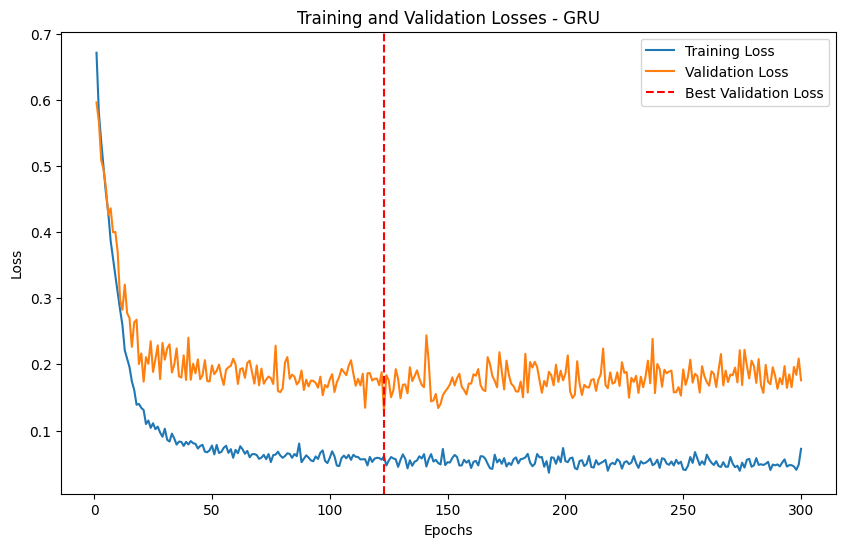

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       711
         1.0       0.89      0.90      0.90       167
         2.0       0.98      0.97      0.97      1734

    accuracy                           0.96      2612
   macro avg       0.93      0.94      0.94      2612
weighted avg       0.96      0.96      0.96      2612

Metrics:
Accuracy: 0.9590
Precision (Macro): 0.9311
Recall (Macro): 0.9420
F1-Score (Macro): 0.9364


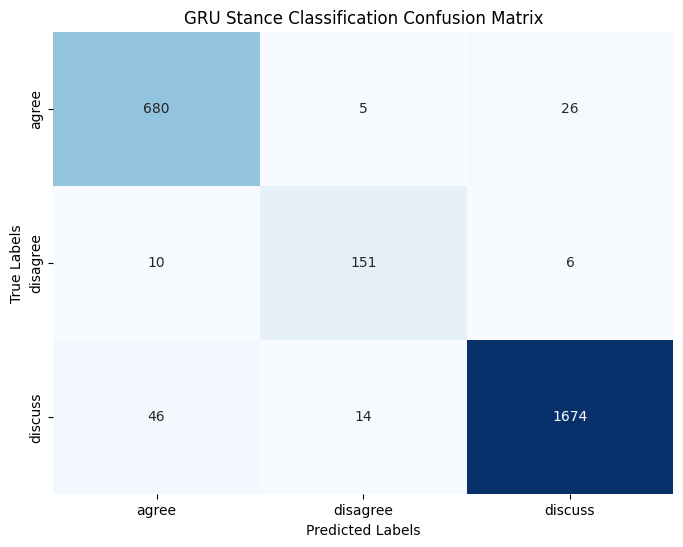

In [40]:
plot_losses(best_val_epoch, train_losses,val_losses,'GRU')




stance_model = GRUModel(train_headlines_transformer.shape[1],hidden_dim,output_dim,num_layers,dropout_rate).to(device)
stance_model.load_state_dict(torch.load('Stance_Model.pt'))
# Set the model to evaluation mode
stance_model.eval()


# Inference loop
with torch.no_grad():

    texts,stances= next(iter(DataLoader(stance_test_dataset,batch_size=len(stance_test_dataset),shuffle=False)))
    stances=stances.to(device)
    outputs=stance_model(texts).to(device)
    probabilities = torch.sigmoid(outputs)
    probabilities=F.normalize(probabilities,dim=0).cpu().numpy().tolist()
    predictions = np.argmax(probabilities, axis=1)


# Convert targets to NumPy array
targets = stances.cpu().numpy()

report = metrics.classification_report(targets, predictions)

print("Classification Report:")
print(report)

# Calculate metrics
accuracy = accuracy_score(targets, predictions)
precision_micro = precision_score(targets, predictions, average='micro')
recall_micro = recall_score(targets, predictions, average='micro')
f1_micro = f1_score(targets, predictions, average='micro')
precision_macro = precision_score(targets, predictions, average='macro')
recall_macro = recall_score(targets, predictions, average='macro')
f1_macro = f1_score(targets, predictions, average='macro')

print("Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

class_labels = ['agree', 'disagree', 'discuss']

# Calculate confusion matrix
conf_matrix = confusion_matrix(targets, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)

# Adding labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('GRU Stance Classification Confusion Matrix')

# Display the plot
plt.show()


5371


100%|██████████| 5371/5371 [00:04<00:00, 1147.96it/s]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       711
         1.0       0.95      0.88      0.91       167
         2.0       0.95      0.98      0.97      1734
         3.0       0.99      0.98      0.99      2759

    accuracy                           0.97      5371
   macro avg       0.95      0.94      0.95      5371
weighted avg       0.97      0.97      0.97      5371



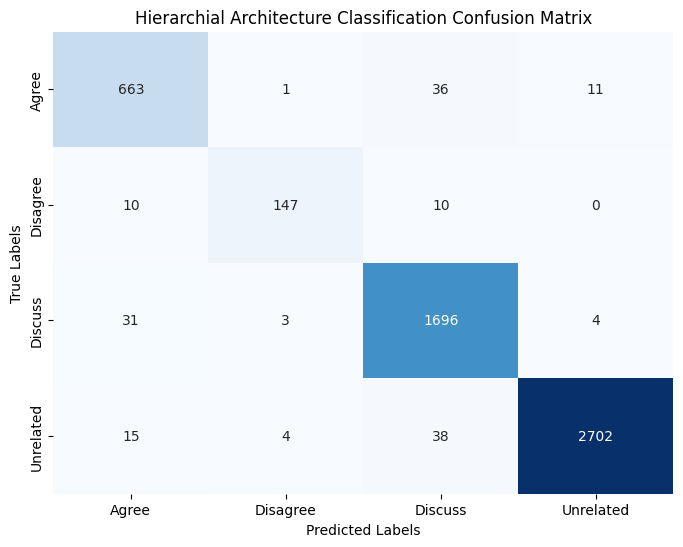

In [39]:
related_classifier =  LSTM(384, 512,1).to(device)
related_classifier.load_state_dict(torch.load('Transformer_LSTM.pt'))
related_classifier.eval()
stance_classifier= GRUModel(384, 128,3,3,0.2).to(device)
stance_classifier.load_state_dict(torch.load('Stance_Model.pt'))
stance_classifier.eval()


test_dataset = TransformerDataset(test_headlines_transformer, test_bodies_transformer, y_test_encoded)
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
all_predictions=[]
all_targets=[]
with torch.no_grad():
    for text, stance in tqdm(test_loader):
        stance = stance.cpu()
        text = text.to(device)
        # Forward pass
        related_predictions = torch.sigmoid(related_classifier(text)).cpu()
        if (related_predictions>0.5):
            stance_predictions = torch.sigmoid(stance_classifier(text)).to(device)
            
            probabilities=F.normalize(stance_predictions,dim=1).cpu().numpy().tolist()
            predictions = np.argmax(probabilities, axis=1)[0]
            all_predictions.append(predictions)
        else:
            all_predictions.append(3) #3 : label for unrelated class
        all_targets.append(stance[0])
        
        
report = metrics.classification_report(all_targets, all_predictions)

print("Classification Report:")
print(report)

targets=all_targets
predictions=all_predictions
accuracy = accuracy_score(targets, predictions)
precision_macro = precision_score(targets, predictions, average='macro')
recall_macro = recall_score(targets, predictions, average='macro')
f1_macro = f1_score(targets, predictions, average='macro')

conf_matrix = confusion_matrix(targets, predictions)
class_labels=['Agree','Disagree','Discuss','Unrelated']
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)

# Adding labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Hierarchial Architecture Classification Confusion Matrix')

# Display the plot
plt.show()

